#Mini Porject 4
##Mansi Patel
## Megha Mathpal
FCNN
LSTM
CNN

In [0]:
import os
import json
import csv
import pandas as pd
import numpy as np
import collections
from scipy.stats import zscore
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

pd.set_option('display.max_colwidth', -1)

#Loading the database

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 4.9MB/s 


In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
root_path = 'gdrive/My Drive/Project 4/'

Mounted at /content/gdrive


In [0]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
""" link = 'https://drive.google.com/open?id=1epxIFUlSWj9p11frJPqHq2hWY03EUQxh'

fluff, file_id = link.split('=')
print (file_id)
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(root_path+'CSC215_Project4_Stock_Price.csv')  """
df = pd.read_csv(root_path+'CSC215_Project4_Stock_Price.csv')
df2 = pd.read_csv(root_path+'CSC215_Project4_Stock_Price.csv')
#print('Downloaded content "{}"'.format(downloaded.GetContentString()))

#Gems to use

In [0]:
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)



# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()


# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


In [0]:
df.dtypes

Date         object 
Open         float64
High         float64
Low          float64
Close        float64
Adj_Close    float64
Volume       int64  
dtype: object

In [0]:
df.describe()

,Open,High,Low,Close,Adj_Close,Volume
count,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4.392000e+03
mean,30.562539,30.893618,30.238833,30.572580,30.572580,1.884027e+06
std,29.914758,30.210974,29.615761,29.905778,29.905778,1.621609e+06
min,3.296875,3.390625,3.000000,3.250000,3.250000,1.904000e+05
25%,8.718125,8.803125,8.625000,8.712500,8.712500,1.088800e+06
50%,14.766250,14.981250,14.662500,14.767500,14.767500,1.539300e+06
75%,42.546248,43.051249,42.086249,42.539999,42.539999,2.188900e+06
max,121.080002,121.750000,120.169998,121.360001,121.360001,4.641260e+07


#Data Preprocessing

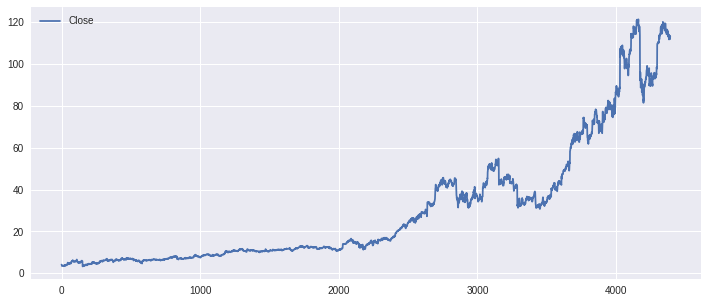

In [0]:
df['Close'].plot(legend=True, figsize=(12,5))

In [0]:
print(df.shape)
df.drop('Date',inplace=True,axis=1)
df.drop('Adj_Close',inplace=True,axis=1)

df.shape

(4392, 7)


(4392, 5)

In [0]:
print(df.shape)
# if any' values are missing in a row, then drop that row. If inplace=True, do operation inplace and return None.
df.dropna(how='any', inplace= True)
df.shape

(4392, 5)


(4392, 5)

In [0]:
print(df.shape)
df.drop_duplicates(inplace=True)
df.shape

(4392, 5)


(4392, 5)

In [0]:
df.head()

,Open,High,Low,Close,Volume
0,3.812500,4.156250,3.812500,4.125000,3675600
1,4.125000,4.125000,4.000000,4.015625,1077600
2,4.000000,4.031250,3.953125,4.000000,437200
3,4.000000,4.000000,3.843750,3.843750,1883600
4,3.734375,3.734375,3.390625,3.390625,7931600


In [0]:
df2.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2000/3/27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,2000/3/28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,2000/3/29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,2000/3/30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,2000/3/31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600


In [0]:
#normalise the features
encode_numeric_zscore(df,'Open')
encode_numeric_zscore(df,'Low')
encode_numeric_zscore(df,'High')
encode_numeric_zscore(df,'Volume')

#Task 1 : FCNN

In [0]:
#getting the correct shape for applying Neural Network
x,y= to_xy(df, 'Close')
print(x.shape,y.shape)

(4392, 4) (4392,)


In [0]:
# Split into train/test - 70/30
x_train01, x_test01, y_train01, y_test01 = train_test_split(x, y, test_size=0.30, random_state=45)
print(x_train01.shape,y_train01.shape)
print(x_test01.shape,y_test01.shape)

(3074, 4) (3074,)
(1318, 4) (1318,)


In [0]:
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers
path = ""
save_path=""

In [0]:
x_test01

array([[ 0.43398175,  0.42439485,  0.4001642 , -0.3481895 ],
       [-0.48805472, -0.492987  , -0.4938699 ,  2.4735763 ],
       [-0.7207994 , -0.7216291 , -0.7186658 , -0.06563059],
       ...,
       [-0.6277015 , -0.6324231 , -0.6257254 , -0.22645853],
       [-0.67282975, -0.6771088 , -0.67215335, -0.6337084 ],
       [ 0.22990191,  0.24465884,  0.23386763,  0.04327361]],
      dtype=float32)

In [0]:
y_test01

array([42.57  , 15.96  ,  8.975 , ..., 11.7425, 10.39  , 37.71  ],
      dtype=float32)

##Model variations

In [0]:

checkpointer = ModelCheckpoint(filepath="neural_project4.hdf5", verbose=0, save_best_only=True) # save best model

#SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
sgd = optimizers.SGD(lr=0.01, decay=0.0, clipvalue=0.5, clipnorm=1.)
#model2.compile(loss='mean_squared_error', optimizer=sgd)
for i in range(5):
  
  print(i)
  model = Sequential()
  model.add(Dense(25, input_dim=x.shape[1], activation='relu'))
  model.add(Dense(15,activation='relu'))
  #model.add(Dense(25,activation='relu'))
  #model.add(Dense(25,activation='relu'))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer="sgd")

  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

  model.fit(x_train01, y_train01,validation_data=(x_test01,y_test01),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
  
  
print('Training finished...Loading the best model')  
print()
model.load_weights('neural_project4.hdf5') # load weights from best model
model.save(os.path.join(save_path,"neural_project4.hdf5"))

Instructions for updating:
Colocations handled automatically by placer.
0
Instructions for updating:
Use tf.cast instead.
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 3s - loss: 494.0744 - val_loss: 210.0484
Epoch 2/100
 - 0s - loss: 141.0902 - val_loss: 265.3844
Epoch 3/100
 - 0s - loss: 132.2763 - val_loss: 78.3383
Epoch 4/100
 - 0s - loss: 189.2822 - val_loss: 94.3379
Epoch 5/100
 - 0s - loss: 99.1250 - val_loss: 646.9402
Epoch 6/100
 - 0s - loss: 103.9485 - val_loss: 86.6312
Epoch 7/100
 - 0s - loss: 83.5172 - val_loss: 76.8959
Epoch 8/100
 - 0s - loss: 94.9164 - val_loss: 1351.2612
Epoch 9/100
 - 0s - loss: 1788.8842 - val_loss: 303.1534
Epoch 10/100
 - 0s - loss: 282.7426 - val_loss: 272.1212
Epoch 11/100
 - 0s - loss: 263.6006 - val_loss: 245.9444
Epoch 12/100
 - 0s - loss: 228.9563 - val_loss: 250.3770
Epoch 00012: early stopping
1
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 0s - loss: 606.8787 - val_loss: 184.1374
Epoch 2/100
 - 0s - loss: 

In [0]:
model.load_weights('neural_project4.hdf5')
pred2 = model.predict(x_test01)
score = np.sqrt(metrics.mean_squared_error(pred2,y_test01))
print("RMSE: {}".format(score))

RMSE: 30.229694366455078


In [0]:
checkpointer = ModelCheckpoint(filepath="neural_project4_1.hdf5", verbose=0, save_best_only=True) # save best model
optimizer = [ 'Adagrad', 'Adam', 'Adamax']
for each in optimizer:
  Adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

  for i in range(2):
  
    print(i)
    model = Sequential()
    model.add(Dense(25, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(25,activation='relu'))
    model.add(Dense(25,activation='relu'))
    model.add(Dense(25,activation='relu'))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer=each)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train01, y_train01,validation_data=(x_test01,y_test01),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    pred2 = model.predict(x_test01)
    score = np.sqrt(metrics.mean_squared_error(pred2,y_test01))
    print("RMSE: {}".format(score))
    print(each,"ends")
    #loop ends
  
print('Training finished...Loading the best model')  
print()
model.load_weights('neural_project4_1.hdf5') # load weights from best model
model.save(os.path.join(save_path,"neural_project4_1.hdf5"))

0
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 3s - loss: 484.8183 - val_loss: 46.7628
Epoch 2/100
 - 1s - loss: 32.6165 - val_loss: 15.2654
Epoch 3/100
 - 1s - loss: 11.3453 - val_loss: 4.8050
Epoch 4/100
 - 1s - loss: 4.2040 - val_loss: 1.7074
Epoch 5/100
 - 1s - loss: 2.0953 - val_loss: 0.9134
Epoch 6/100
 - 1s - loss: 1.2197 - val_loss: 0.5452
Epoch 7/100
 - 1s - loss: 0.7462 - val_loss: 0.3732
Epoch 8/100
 - 1s - loss: 0.5167 - val_loss: 0.3018
Epoch 9/100
 - 0s - loss: 0.4249 - val_loss: 0.4278
Epoch 10/100
 - 1s - loss: 0.3579 - val_loss: 0.2671
Epoch 11/100
 - 0s - loss: 0.3219 - val_loss: 0.2491
Epoch 12/100
 - 1s - loss: 0.3058 - val_loss: 0.2747
Epoch 13/100
 - 0s - loss: 0.2906 - val_loss: 0.2485
Epoch 14/100
 - 0s - loss: 0.2829 - val_loss: 0.2353
Epoch 15/100
 - 0s - loss: 0.2707 - val_loss: 0.2659
Epoch 16/100
 - 1s - loss: 0.2632 - val_loss: 0.2185
Epoch 17/100
 - 1s - loss: 0.2563 - val_loss: 0.2163
Epoch 18/100
 - 1s - loss: 0.2490 - val_loss: 0.2104

In [0]:
model.load_weights('neural_project4_1.hdf5')
pred2 = model.predict(x_test01)
score = np.sqrt(metrics.mean_squared_error(pred2,y_test01))
print("RMSE: {}".format(score))

RMSE: 0.39536982774734497


In [0]:
checkpointer = ModelCheckpoint(filepath="neural_project4_1.hdf5", verbose=0, save_best_only=True) # save best model
optimizer = ['SGD']
for each in optimizer:
  SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  sgd = optimizers.SGD(lr=0.01, decay=0.0, clipvalue=0.5, clipnorm=1.)
  #Adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  #Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  #Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

  for i in range(6):
  
    print(i)
    model = Sequential()
    model.add(Dense(32, input_dim=x.shape[1], activation='relu'))
   # model.add(Dropout(0.01))
    model.add(Dense(16,activation='relu'))
    #model.add(Dense(25,activation='relu'))
    #model.add(Dense(25,activation='relu'))
   # model.add(Dropout(0.01))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer=sgd)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train01, y_train01,validation_data=(x_test01,y_test01),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    pred2 = model.predict(x_test01)
    score = np.sqrt(metrics.mean_squared_error(pred2,y_test01))
    print("RMSE: {}".format(score))
    print(each,"ends")
    #loop ends
  
print('Training finished...Loading the best model')  
print()
#model.load_weights('neural_project4_1.hdf5') # load weights from best model
#model.save(os.path.join(save_path,"neural_project4_1.hdf5"))

0
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 2s - loss: 1742.9353 - val_loss: 1710.1451
Epoch 2/100
 - 0s - loss: 1463.3050 - val_loss: 1333.8973
Epoch 3/100
 - 0s - loss: 1022.0654 - val_loss: 758.0195
Epoch 4/100
 - 0s - loss: 468.5664 - val_loss: 211.3227
Epoch 5/100
 - 0s - loss: 118.2747 - val_loss: 78.8800
Epoch 6/100
 - 0s - loss: 58.1262 - val_loss: 34.6962
Epoch 7/100
 - 0s - loss: 23.2905 - val_loss: 10.5808
Epoch 8/100
 - 0s - loss: 5.4302 - val_loss: 1.9159
Epoch 9/100
 - 0s - loss: 1.2443 - val_loss: 0.5821
Epoch 10/100
 - 0s - loss: 0.4954 - val_loss: 0.4321
Epoch 11/100
 - 0s - loss: 0.2973 - val_loss: 0.2982
Epoch 12/100
 - 0s - loss: 0.2616 - val_loss: 0.2510
Epoch 13/100
 - 0s - loss: 0.2227 - val_loss: 0.1884
Epoch 14/100
 - 0s - loss: 0.2051 - val_loss: 0.2106
Epoch 15/100
 - 0s - loss: 0.1977 - val_loss: 0.2055
Epoch 16/100
 - 0s - loss: 0.1958 - val_loss: 0.1894
Epoch 17/100
 - 0s - loss: 0.1837 - val_loss: 0.1882
Epoch 18/100
 - 0s - loss: 0.1

In [0]:

checkpointer = ModelCheckpoint(filepath="neural_project4_1.hdf5", verbose=0, save_best_only=True) # save best model
optimizer = [ 'Adam', 'Adamax']
for each in optimizer:
  Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  Adagrad = optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)

  for i in range(6):
  
    print(i)
    model = Sequential()
    model.add(Dense(50, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(25,activation='relu'))
    #model.add(Dense(25,activation='relu'))
    #model.add(Dense(25,activation='relu'))
 
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer=each)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train01, y_train01,validation_data=(x_test01,y_test01),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    pred2 = model.predict(x_test01)
    score = np.sqrt(metrics.mean_squared_error(pred2,y_test01))
    print("RMSE: {}".format(score))
    print(each,"ends")
    #loop ends
  
print('Training finished...Loading the best model')  
print()
#model.load_weights('neural_project4_1.hdf5') # load weights from best model
#model.save(os.path.join(save_path,"neural_project4_1.hdf5"))

0
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 1s - loss: 1661.3077 - val_loss: 1469.5772
Epoch 2/100
 - 0s - loss: 871.8326 - val_loss: 305.3322
Epoch 3/100
 - 0s - loss: 108.9601 - val_loss: 52.9604
Epoch 4/100
 - 0s - loss: 46.7056 - val_loss: 33.1591
Epoch 5/100
 - 0s - loss: 30.4690 - val_loss: 21.6149
Epoch 6/100
 - 0s - loss: 19.7292 - val_loss: 13.5513
Epoch 7/100
 - 0s - loss: 12.7107 - val_loss: 8.3393
Epoch 8/100
 - 0s - loss: 7.7800 - val_loss: 4.7784
Epoch 9/100
 - 0s - loss: 4.6427 - val_loss: 2.9797
Epoch 10/100
 - 0s - loss: 2.9242 - val_loss: 1.9224
Epoch 11/100
 - 0s - loss: 1.9705 - val_loss: 1.3358
Epoch 12/100
 - 0s - loss: 1.4166 - val_loss: 1.0562
Epoch 13/100
 - 0s - loss: 1.0647 - val_loss: 0.8115
Epoch 14/100
 - 0s - loss: 0.8728 - val_loss: 0.6786
Epoch 15/100
 - 0s - loss: 0.7004 - val_loss: 0.5723
Epoch 16/100
 - 0s - loss: 0.5885 - val_loss: 0.5309
Epoch 17/100
 - 0s - loss: 0.5007 - val_loss: 0.4353
Epoch 18/100
 - 0s - loss: 0.4571 - va

In [0]:
from keras.layers.core import Dropout
checkpointer = ModelCheckpoint(filepath="neural_project4.hdf5", verbose=0, save_best_only=True) # save best model
Adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)

for i in range(6):
  print(i)
  model = Sequential()
  model.add(Dense(32, input_dim=x.shape[1], activation='relu'))
  model.add(Dense(16,activation='relu'))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='Adam')

  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

  model.fit(x_train01, y_train01,validation_data=(x_test01,y_test01),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
  pred2 = model.predict(x_test01)

  score = np.sqrt(metrics.mean_squared_error(pred2,y_test01))
  print("RMSE: {}".format(score))
  #loop ends
  
print('Training finished')  
print()
#model.save(os.path.join(save_path,"neural_project3mc.hdf5"))

0
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 1s - loss: 1661.1291 - val_loss: 1500.9875
Epoch 2/100
 - 0s - loss: 961.8658 - val_loss: 441.9272
Epoch 3/100
 - 0s - loss: 174.8899 - val_loss: 70.5694
Epoch 4/100
 - 0s - loss: 64.1004 - val_loss: 49.3115
Epoch 5/100
 - 0s - loss: 45.5090 - val_loss: 33.1332
Epoch 6/100
 - 0s - loss: 29.8815 - val_loss: 20.7028
Epoch 7/100
 - 0s - loss: 18.6305 - val_loss: 11.7635
Epoch 8/100
 - 0s - loss: 10.8372 - val_loss: 6.4950
Epoch 9/100
 - 0s - loss: 6.0241 - val_loss: 3.4578
Epoch 10/100
 - 0s - loss: 3.4986 - val_loss: 2.0514
Epoch 11/100
 - 0s - loss: 2.1217 - val_loss: 1.3239
Epoch 12/100
 - 0s - loss: 1.3968 - val_loss: 0.9068
Epoch 13/100
 - 0s - loss: 0.9498 - val_loss: 0.6731
Epoch 14/100
 - 0s - loss: 0.7093 - val_loss: 0.5272
Epoch 15/100
 - 0s - loss: 0.5553 - val_loss: 0.4406
Epoch 16/100
 - 0s - loss: 0.4718 - val_loss: 0.3918
Epoch 17/100
 - 0s - loss: 0.3844 - val_loss: 0.3435
Epoch 18/100
 - 0s - loss: 0.3271 - 

In [0]:
from keras.layers.core import Dropout
checkpointer = ModelCheckpoint(filepath="neural_project4_11.hdf5", verbose=0, save_best_only=True) # save best model
Adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)

for i in range(7):
  print(i)
  model = Sequential()
  model.add(Dense(32, input_dim=x.shape[1], activation='relu'))
  model.add(Dense(16,activation='relu'))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='Adam')

  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

  model.fit(x_train01, y_train01,validation_data=(x_test01,y_test01),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
  pred2 = model.predict(x_test01)

  score = np.sqrt(metrics.mean_squared_error(pred2,y_test01))
  print("RMSE: {}".format(score))
  #loop ends
  
print('Training finished')  
print()
model.load_weights('neural_project4_11.hdf5') # load weights from best model
model.save(os.path.join(save_path,"neural_project4_11.hdf5"))
#model.save(os.path.join(save_path,"neural_project3mc.hdf5"))

0
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 5s - loss: 1691.0629 - val_loss: 1576.3833
Epoch 2/100
 - 1s - loss: 1050.3006 - val_loss: 551.3461
Epoch 3/100
 - 1s - loss: 217.8114 - val_loss: 62.2380
Epoch 4/100
 - 1s - loss: 54.4009 - val_loss: 39.4141
Epoch 5/100
 - 1s - loss: 35.3547 - val_loss: 23.0485
Epoch 6/100
 - 1s - loss: 20.4903 - val_loss: 11.5464
Epoch 7/100
 - 1s - loss: 10.6517 - val_loss: 5.3486
Epoch 8/100
 - 1s - loss: 5.4939 - val_loss: 2.7204
Epoch 9/100
 - 1s - loss: 3.1125 - val_loss: 1.4934
Epoch 10/100
 - 1s - loss: 1.8085 - val_loss: 0.8803
Epoch 11/100
 - 1s - loss: 1.1157 - val_loss: 0.5628
Epoch 12/100
 - 1s - loss: 0.7506 - val_loss: 0.4321
Epoch 13/100
 - 1s - loss: 0.5507 - val_loss: 0.3799
Epoch 14/100
 - 1s - loss: 0.4423 - val_loss: 0.3248
Epoch 15/100
 - 1s - loss: 0.3731 - val_loss: 0.3394
Epoch 16/100
 - 1s - loss: 0.3428 - val_loss: 0.2948
Epoch 17/100
 - 1s - loss: 0.3167 - val_loss: 0.2927
Epoch 18/100
 - 1s - loss: 0.3061 - v

In [0]:
from keras.layers.core import Dropout
checkpointer = ModelCheckpoint(filepath="neural_project4_12.hdf5", verbose=0, save_best_only=True) # save best model
Adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)

for i in range(6):
  print(i)
  model = Sequential()
  model.add(Dense(32, input_dim=x.shape[1], activation='relu'))
  model.add(Dense(16,activation='relu'))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='Adam')

  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

  model.fit(x_train01, y_train01,validation_data=(x_test01,y_test01),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
  pred2 = model.predict(x_test01)

  score = np.sqrt(metrics.mean_squared_error(pred2,y_test01))
  print("RMSE: {}".format(score))
  #loop ends
  
print('Training finished')  
print()
model.load_weights('neural_project4_12.hdf5') # load weights from best model
model.save(os.path.join(save_path,"neural_project4_12.hdf5"))
#model.save(os.path.join(save_path,"neural_project3mc.hdf5"))

0
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 6s - loss: 1729.7034 - val_loss: 1679.1609
Epoch 2/100
 - 1s - loss: 1253.7384 - val_loss: 803.9143
Epoch 3/100
 - 1s - loss: 341.1270 - val_loss: 83.1163
Epoch 4/100
 - 1s - loss: 58.4876 - val_loss: 39.6528
Epoch 5/100
 - 1s - loss: 35.0055 - val_loss: 23.5345
Epoch 6/100
 - 1s - loss: 21.7852 - val_loss: 14.7769
Epoch 7/100
 - 1s - loss: 14.1284 - val_loss: 9.5610
Epoch 8/100
 - 1s - loss: 9.2082 - val_loss: 6.2797
Epoch 9/100
 - 1s - loss: 6.1325 - val_loss: 4.2082
Epoch 10/100
 - 1s - loss: 4.2432 - val_loss: 3.0373
Epoch 11/100
 - 1s - loss: 3.0568 - val_loss: 2.3595
Epoch 12/100
 - 1s - loss: 2.3872 - val_loss: 1.9010
Epoch 13/100
 - 1s - loss: 1.9038 - val_loss: 1.5952
Epoch 14/100
 - 1s - loss: 1.5593 - val_loss: 1.3511
Epoch 15/100
 - 1s - loss: 1.3056 - val_loss: 1.1391
Epoch 16/100
 - 1s - loss: 1.0975 - val_loss: 0.9677
Epoch 17/100
 - 1s - loss: 0.9408 - val_loss: 0.8515
Epoch 18/100
 - 1s - loss: 0.8224 - v

##best model

In [0]:
#loading the best saved model
from keras.models import load_model
model1 = load_model(os.path.join(save_path,"neural_project4_12.hdf5"))
pred1 = model1.predict(x_test01)
print (pred1.shape)
# Measure RMSE error.  RMSE is common for regression.
fcnn = np.sqrt(metrics.mean_squared_error(pred1,y_test01))
print("After load score (RMSE): {}".format(fcnn))
fcnnr2=metrics.r2_score(pred1,y_test01)
print ("R2 score:",fcnnr2)

(1318, 1)
After load score (RMSE): 0.3785302937030792
R2 score: 0.9998432358445976


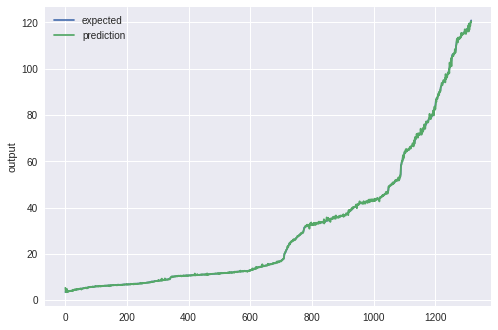

In [0]:
pred = [x for [x] in pred1]
chart_regression(pred,y_test01)

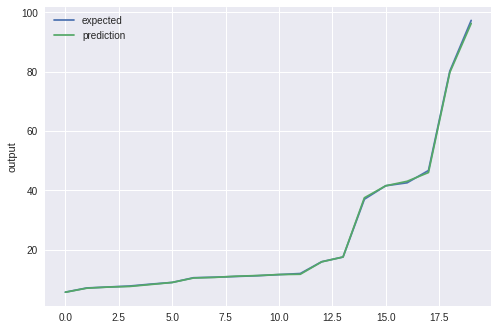

In [0]:
chart_regression(pred[0:20],y_test01[0:20])

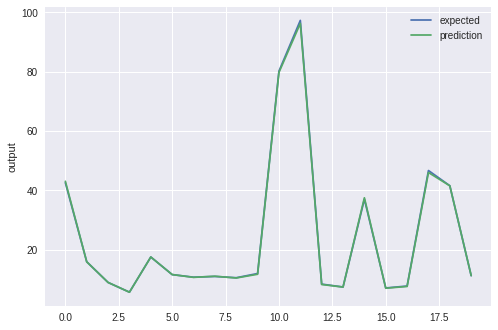

In [0]:
chart_regression(pred[0:20],y_test01[0:20],sort=False)

# Task 2 : LSTM

In [0]:
encode_numeric_zscore(df,'Close')

In [0]:
import numpy as np

def to_sequences(SEQUENCE_SIZE, data, col):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i+1:(i+SEQUENCE_SIZE+1)]
        after_window = col[i+SEQUENCE_SIZE]
        window = [x for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
     
        
    return np.array(x),np.array(y)

In [0]:
def list_convert(x):
  x1 = []
  for i in range(0,x.shape[0]):
    x1.append(x.iloc[i,:].tolist())
  return x1

In [0]:
df_train = df[0:3074]
df_test = df[3074:4392]
df_y_train = y[0:3074]
df_y_test = y[3074:4392]
#df_y_train = df_train['Close'].tolist()
#df_y_test = df_test['Close'].tolist()


In [0]:
df_train1 = df2[0:3074]
df_test1 = df2[3074:4392]
df_y_train1 = y[0:3074]
df_y_test1 = y[3074:4392]
df_test1 = list_convert(df_test1)
df_train1 = list_convert(df_train1)

SEQUENCE_SIZE = 7
x_train1,y_train1 = to_sequences(SEQUENCE_SIZE,df_train1,df_y_train1)
x_test1,y_test1 = to_sequences(SEQUENCE_SIZE,df_test1,df_y_test1)
print(x_train1.shape,y_train1.shape)
print(x_test1.shape,y_test1.shape)

#df_y_train = df_train['Close'].tolist()
#df_y_test = df_test['Close'].tolist()


(3066, 7, 7) (3066,)
(1310, 7, 7) (1310,)


In [0]:
df_test[0:5]

,Open,High,Low,Close,Volume
3074,0.502844,0.615882,0.518851,0.597457,3.950628
3075,0.606639,0.592049,0.608499,0.608157,0.554864
3076,0.599452,0.644679,0.614746,0.660656,0.824103
3077,0.658453,0.702771,0.668771,0.691085,1.002815
3078,0.688538,0.689861,0.686161,0.681053,0.543394


In [0]:
df_test = list_convert(df_test)

In [0]:
df_test[0:5]

[[0.5028441428939177,
  0.6158815616448052,
  0.5188509886160804,
  0.5974570804584536,
  3.9506279373264084],
 [0.6066390313451373,
  0.5920491294409321,
  0.6084991328624626,
  0.6081573203071348,
  0.5548643319362047],
 [0.5994519433566993,
  0.6446790107940943,
  0.6147458742844409,
  0.660655669875068,
  0.824103134484667],
 [0.6584528880660258,
  0.7027705167089877,
  0.668771094453316,
  0.6910845720350747,
  1.0028145522092304],
 [0.6885384395254223,
  0.6898613336285779,
  0.686160585229324,
  0.6810529655134169,
  0.5433942409435308]]

In [0]:
df_train = list_convert(df_train)

In [0]:
df_train[0:5]

[[-0.8942087629516549,
  -0.8850216978567287,
  -0.8923064090229872,
  -0.8843635445874727,
  1.1048120280258031],
 [-0.8837624141312507,
  -0.8860560901789214,
  -0.8859753206205867,
  -0.8880208645586273,
  -0.49730068159605945],
 [-0.8879409536594124,
  -0.8891592671454993,
  -0.8875580927211868,
  -0.8885433388402209,
  -0.8922171478169374],
 [-0.8879409536594124,
  -0.890193659467692,
  -0.8912512276225871,
  -0.8937680816561561,
  -0.00026340524685955876],
 [-0.8968203501567559,
  -0.8989859942063295,
  -0.9065513579283885,
  -0.9089198358223681,
  3.7293661820483774]]

In [0]:

SEQUENCE_SIZE = 7
x_train,y_train = to_sequences(SEQUENCE_SIZE,df_train,df_y_train)
x_test,y_test = to_sequences(SEQUENCE_SIZE,df_test,df_y_test)


In [0]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(3066, 7, 5) (3066,)
(1310, 7, 5) (1310,)


In [0]:
x_train[0:5]

array([[[-8.83762414e-01, -8.86056090e-01, -8.85975321e-01,
         -8.88020865e-01, -4.97300682e-01],
        [-8.87940954e-01, -8.89159267e-01, -8.87558093e-01,
         -8.88543339e-01, -8.92217148e-01],
        [-8.87940954e-01, -8.90193659e-01, -8.91251228e-01,
         -8.93768082e-01, -2.63405247e-04],
        [-8.96820350e-01, -8.98985994e-01, -9.06551358e-01,
         -9.08919836e-01,  3.72936618e+00],
        [-9.04655112e-01, -9.00020387e-01, -9.04968586e-01,
         -9.07352413e-01,  5.92175691e+00],
        [-9.03610477e-01, -9.04157956e-01, -9.16575581e-01,
         -9.05262516e-01,  6.93926498e+00],
        [-9.05699747e-01, -9.04675152e-01, -9.04440995e-01,
         -9.05784990e-01,  2.75379178e+00]],

       [[-8.87940954e-01, -8.89159267e-01, -8.87558093e-01,
         -8.88543339e-01, -8.92217148e-01],
        [-8.87940954e-01, -8.90193659e-01, -8.91251228e-01,
         -8.93768082e-01, -2.63405247e-04],
        [-8.96820350e-01, -8.98985994e-01, -9.06551358e-01,
  

In [0]:
y_train[0:5]

array([3.484375, 3.578125, 3.609375, 3.640625, 3.578125], dtype=float32)

In [0]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers
path = ""
save_path=""
from sklearn import metrics

## Model Variations 

In [0]:

checkpointer = ModelCheckpoint(filepath="lstm_neural_project4.hdf5", verbose=0, save_best_only=True) # save best model
optimizer = [ 'Adam','SGD']
for each in optimizer:
  SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  Adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  

  for i in range(2):
  
    print(i)
    model = Sequential()
   
    model.add(LSTM(128, activation='relu', dropout=0.2,return_sequences=True, recurrent_dropout=0.2, input_shape=(7, 5)))

    model.add(LSTM(128, activation='relu', dropout=0.2,return_sequences=True, recurrent_dropout=0.2))
  
    model.add(LSTM(128, activation='sigmoid', dropout=0.2, recurrent_dropout=0.2))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
              optimizer=each)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    pred = model.predict(x_test)
    score2 = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("(RMSE): {}".format(score2))
    print(each,"ends")
    #model.load_weights('neural_project4.hdf5') # load weights from best model
    model.save(os.path.join(save_path,"lstm_neural_project4.hdf5"))

Instructions for updating:
Colocations handled automatically by placer.
0
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train...
Instructions for updating:
Use tf.cast instead.
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 10s - loss: 164.4092 - val_loss: 3731.0849
Epoch 2/100
 - 6s - loss: 121.3671 - val_loss: 3535.9126
Epoch 3/100
 - 6s - loss: 120.6258 - val_loss: 3541.9185
Epoch 4/100
 - 6s - loss: 120.6089 - val_loss: 3515.8279
Epoch 5/100
 - 6s - loss: 114.7486 - val_loss: 3379.7072
Epoch 6/100
 - 6s - loss: 69.3283 - val_loss: 2700.0555
Epoch 7/100
 - 6s - loss: 43.8613 - val_loss: 2380.4750
Epoch 8/100
 - 6s - loss: 37.8496 - val_loss: 2265.9185
Epoch 9/100
 - 6s - loss: 34.5086 - val_loss: 2253.1798
Epoch 10/100
 - 6s - loss: 33.0785 - val_loss: 2089.0496
Epoch 11/100
 - 6s - loss: 27.8027 - val_loss: 2073.4693
Epoch 12/100
 - 6s - loss: 24.2426 - val_loss: 2017.7067
Epoch 13/100
 - 6s - loss

In [0]:

checkpointer = ModelCheckpoint(filepath="lstm_neural_project4.hdf5", verbose=0, save_best_only=True) # save best model
optimizer = ['Adam','SGD','Adamax']
for each in optimizer:
  SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  Adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

  for i in range(1):
  
    print(i)
    model = Sequential()
   
    model.add(LSTM(128, activation='relu', dropout=0.2,return_sequences=True, recurrent_dropout=0.2, input_shape=(7, 5)))

    model.add(LSTM(64, activation='relu', dropout=0.2, recurrent_dropout=0.2))
  
    #model.add(LSTM(128, activation='sigmoid', dropout=0.2, recurrent_dropout=0.2))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
              optimizer=each)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    pred = model.predict(x_test)
    score2 = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("(RMSE): {}".format(score2))
    print(each,"ends")
    #model.load_weights('neural_project4.hdf5') # load weights from best model
    #model.save(os.path.join(save_path,"lstm_neural_project4.hdf5"))

0
Train...
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 10s - loss: 203.7918 - val_loss: 89659.5327
Epoch 2/100
 - 5s - loss: 29.8821 - val_loss: 4239.0229
Epoch 3/100
 - 5s - loss: 14.0525 - val_loss: 896.4493
Epoch 4/100
 - 5s - loss: 8.8926 - val_loss: 587.3945
Epoch 5/100
 - 5s - loss: 7.0240 - val_loss: 439.1738
Epoch 6/100
 - 4s - loss: 5.9482 - val_loss: 446.1964
Epoch 7/100
 - 5s - loss: 5.5061 - val_loss: 390.5402
Epoch 8/100
 - 5s - loss: 5.1369 - val_loss: 238.2992
Epoch 9/100
 - 5s - loss: 4.8818 - val_loss: 312.1061
Epoch 10/100
 - 5s - loss: 4.2814 - val_loss: 324.7753
Epoch 11/100
 - 5s - loss: 4.3034 - val_loss: 36.3274
Epoch 12/100
 - 5s - loss: 3.6632 - val_loss: 23.0971
Epoch 13/100
 - 4s - loss: 3.7011 - val_loss: 30.5391
Epoch 14/100
 - 4s - loss: 3.5563 - val_loss: 18.4558
Epoch 15/100
 - 5s - loss: 3.1032 - val_loss: 11.2328
Epoch 16/100
 - 5s - loss: 2.8635 - val_loss: 24.6287
Epoch 17/100
 - 5s - loss: 3.0181 - val_loss: 31.1579
Epoch 18/100
 

In [0]:
for i in range(3):
  
  print(i)
  model = Sequential()
   
  model.add(LSTM(128, activation='relu', dropout=0.2, recurrent_dropout=0.1, input_shape=(7, 5)))

#model.add(LSTM(64, activation='relu', dropout=0.2, recurrent_dropout=0.2))
  
    #model.add(LSTM(128, activation='sigmoid', dropout=0.2, recurrent_dropout=0.2))

  model.add(Dense(1))
  model.compile(loss='mean_squared_error',
              optimizer='adam')

  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
  print('Train...')
  model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
  pred = model.predict(x_test)
  score2 = np.sqrt(metrics.mean_squared_error(pred,y_test))
  print("(RMSE): {}".format(score2))

0
Train...
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 15s - loss: 225.6984 - val_loss: 320792.8044
Epoch 2/100
 - 2s - loss: 44.6173 - val_loss: 635.8334
Epoch 3/100
 - 2s - loss: 10.2511 - val_loss: 52.1807
Epoch 4/100
 - 2s - loss: 7.2322 - val_loss: 41.5875
Epoch 5/100
 - 2s - loss: 5.9589 - val_loss: 153.9327
Epoch 6/100
 - 2s - loss: 5.0974 - val_loss: 76.9456
Epoch 7/100
 - 2s - loss: 4.3208 - val_loss: 244.9605
Epoch 8/100
 - 2s - loss: 4.0743 - val_loss: 76.3199
Epoch 9/100
 - 2s - loss: 3.9932 - val_loss: 821.0668
Epoch 00009: early stopping
(RMSE): 28.65426254272461
1
Train...
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 16s - loss: 238.5411 - val_loss: 135666.9801
Epoch 2/100
 - 2s - loss: 48.5874 - val_loss: 4701.8260
Epoch 3/100
 - 2s - loss: 12.5843 - val_loss: 343.6763
Epoch 4/100
 - 2s - loss: 7.9857 - val_loss: 284.9959
Epoch 5/100
 - 2s - loss: 6.8245 - val_loss: 294.4292
Epoch 6/100
 - 2s - loss: 5.4266 - val_loss: 163.3924
Epoch

In [0]:
for i in range(3):
  
  print(i)
  model = Sequential()
   
  model.add(LSTM(32, activation='relu', dropout=0.2, recurrent_dropout=0.2, input_shape=(7, 5)))
  
#model.add(LSTM(64, activation='relu', dropout=0.2, recurrent_dropout=0.2))
  
    #model.add(LSTM(128, activation='sigmoid', dropout=0.2, recurrent_dropout=0.2))

  model.add(Dense(1))
  model.compile(loss='mean_squared_error',
              optimizer='adam')

  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
  print('Train...')
  model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
  pred = model.predict(x_test)
  score2 = np.sqrt(metrics.mean_squared_error(pred,y_test))
  print("(RMSE): {}".format(score2))

0
Train...
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 10s - loss: 316.8784 - val_loss: 5152.7396
Epoch 2/100
 - 2s - loss: 193.1362 - val_loss: 7334.6911
Epoch 3/100
 - 2s - loss: 43.3908 - val_loss: 396.2259
Epoch 4/100
 - 2s - loss: 25.4917 - val_loss: 124.3206
Epoch 5/100
 - 2s - loss: 18.9833 - val_loss: 62.0277
Epoch 6/100
 - 2s - loss: 16.1816 - val_loss: 55.5032
Epoch 7/100
 - 2s - loss: 14.4071 - val_loss: 22.5075
Epoch 8/100
 - 2s - loss: 12.3073 - val_loss: 13.3013
Epoch 9/100
 - 2s - loss: 11.3324 - val_loss: 12.0505
Epoch 10/100
 - 2s - loss: 10.7506 - val_loss: 24.6045
Epoch 11/100
 - 2s - loss: 9.3361 - val_loss: 38.5847
Epoch 12/100
 - 2s - loss: 8.7792 - val_loss: 46.9573
Epoch 13/100
 - 2s - loss: 8.4580 - val_loss: 32.4641
Epoch 14/100
 - 2s - loss: 8.2582 - val_loss: 63.2342
Epoch 00014: early stopping
(RMSE): 7.951992988586426
1
Train...
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 11s - loss: 302.5982 - val_loss: 1371.0048
Epoc

In [0]:
for i in range(3):
  
  print(i)
  model = Sequential()
   
  model.add(LSTM(64, activation='relu', dropout=0.1, recurrent_dropout=0.1, input_shape=(7, 5)))
  
#model.add(LSTM(64, activation='relu', dropout=0.2, recurrent_dropout=0.2))
  
    #model.add(LSTM(128, activation='sigmoid', dropout=0.2, recurrent_dropout=0.2))

  model.add(Dense(1))
  model.compile(loss='mean_squared_error',
              optimizer='adam')

  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
  print('Train...')
  model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
  pred = model.predict(x_test)
  score2 = np.sqrt(metrics.mean_squared_error(pred,y_test))
  print("(RMSE): {}".format(score2))

0
Train...
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 11s - loss: 269.7748 - val_loss: 521837.4076
Epoch 2/100
 - 2s - loss: 64.6071 - val_loss: 1319.1728
Epoch 3/100
 - 2s - loss: 13.9931 - val_loss: 369.1666
Epoch 4/100
 - 2s - loss: 10.1009 - val_loss: 105.0536
Epoch 5/100
 - 2s - loss: 7.4960 - val_loss: 115.8526
Epoch 6/100
 - 2s - loss: 6.9042 - val_loss: 111.5211
Epoch 7/100
 - 2s - loss: 5.7171 - val_loss: 107.0253
Epoch 8/100
 - 2s - loss: 4.8202 - val_loss: 54.5946
Epoch 9/100
 - 2s - loss: 4.4724 - val_loss: 65.6897
Epoch 10/100
 - 2s - loss: 3.8434 - val_loss: 65.3738
Epoch 11/100
 - 2s - loss: 3.8032 - val_loss: 55.4577
Epoch 12/100
 - 2s - loss: 3.6276 - val_loss: 40.1874
Epoch 13/100
 - 2s - loss: 3.2484 - val_loss: 85.0303
Epoch 14/100
 - 2s - loss: 3.0133 - val_loss: 36.2431
Epoch 15/100
 - 2s - loss: 2.9789 - val_loss: 31.9315
Epoch 16/100
 - 2s - loss: 2.7888 - val_loss: 20.8540
Epoch 17/100
 - 2s - loss: 2.6230 - val_loss: 34.3448
Epoch 18/100
 -

In [0]:
for i in range(3):
  
  print(i)
  model = Sequential()
   
  model.add(LSTM(32, activation='relu', dropout=0.1, recurrent_dropout=0.1, input_shape=(7, 5)))
  
#model.add(LSTM(64, activation='relu', dropout=0.2, recurrent_dropout=0.2))
  
    #model.add(LSTM(128, activation='sigmoid', dropout=0.2, recurrent_dropout=0.2))

  model.add(Dense(1))
  model.compile(loss='mean_squared_error',
              optimizer='adam')

  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
  print('Train...')
  model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
  pred = model.predict(x_test)
  score2 = np.sqrt(metrics.mean_squared_error(pred,y_test))
  print("(RMSE): {}".format(score2))

0
Train...
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 17s - loss: 315.4237 - val_loss: 1701.4373
Epoch 2/100
 - 2s - loss: 165.2026 - val_loss: 81219.6022
Epoch 3/100
 - 2s - loss: 36.9764 - val_loss: 13558.0378
Epoch 4/100
 - 2s - loss: 18.7975 - val_loss: 8012.8841
Epoch 5/100
 - 2s - loss: 15.1144 - val_loss: 4887.8881
Epoch 6/100
 - 2s - loss: 11.6368 - val_loss: 3170.1898
Epoch 00006: early stopping
(RMSE): 56.304439544677734
1
Train...
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 17s - loss: 306.2741 - val_loss: 4671.6975
Epoch 2/100
 - 2s - loss: 140.5604 - val_loss: 43960.6829
Epoch 3/100
 - 2s - loss: 36.6608 - val_loss: 7536.2550
Epoch 4/100
 - 2s - loss: 20.4949 - val_loss: 3132.9815
Epoch 5/100
 - 2s - loss: 16.0272 - val_loss: 1508.2634
Epoch 6/100
 - 2s - loss: 13.8302 - val_loss: 988.6332
Epoch 7/100
 - 2s - loss: 10.9238 - val_loss: 553.6350
Epoch 8/100
 - 2s - loss: 26.5460 - val_loss: 27.9611
Epoch 9/100
 - 2s - loss: 9.1213 - val

In [0]:
#best model lstm
checkpointer = ModelCheckpoint(filepath="lstm_neural_project4.hdf5", verbose=0, save_best_only=True) # save best model
optimizer = ['Adam']
for each in optimizer:
  Adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)

  for i in range(3):
  
    print(i)
    model = Sequential()
   
    model.add(LSTM(128, activation='relu',return_sequences=True,dropout=0.2, recurrent_dropout=0.2, input_shape=(7, 5)))

    model.add(LSTM(64, activation='relu', dropout=0.2,recurrent_dropout=0.2))
  
    #model.add(LSTM(128, activation='sigmoid', dropout=0.2, recurrent_dropout=0.2))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
              optimizer=each)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    pred = model.predict(x_test)
    score2 = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("(RMSE): {}".format(score2))
    print(each,"ends")
    #model.load_weights('neural_project4.hdf5') # load weights from best model
    #model.save(os.path.join(save_path,"lstm_neural_project4.hdf5"))

Instructions for updating:
Colocations handled automatically by placer.
0
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train...
Instructions for updating:
Use tf.cast instead.
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 6s - loss: 256.1357 - val_loss: 379619.8978
Epoch 2/100
 - 3s - loss: 33.3498 - val_loss: 5662.8174
Epoch 3/100
 - 3s - loss: 17.2736 - val_loss: 1330.5742
Epoch 4/100
 - 3s - loss: 11.4242 - val_loss: 455.8690
Epoch 5/100
 - 3s - loss: 8.2603 - val_loss: 248.2505
Epoch 6/100
 - 3s - loss: 7.5646 - val_loss: 204.1210
Epoch 7/100
 - 3s - loss: 6.2548 - val_loss: 89.1792
Epoch 8/100
 - 3s - loss: 5.7478 - val_loss: 21.0405
Epoch 9/100
 - 3s - loss: 5.3262 - val_loss: 40.4026
Epoch 10/100
 - 3s - loss: 4.9671 - val_loss: 22.5780
Epoch 11/100
 - 3s - loss: 4.6450 - val_loss: 11.4782
Epoch 12/100
 - 3s - loss: 4.2907 - val_loss: 15.2470
Epoch 13/100
 - 3s - loss: 3.9783 - val_loss: 37.13

##best model

In [0]:
#loading the best saved model
from keras.models import load_model
model1 = load_model(os.path.join(save_path,"lstm_neural_project4_11.hdf5"))
pred1 = model1.predict(x_test)
print (pred1.shape)
# Measure RMSE error.  RMSE is common for regression.
lstm = np.sqrt(metrics.mean_squared_error(pred1,y_test))
print("Predicted classes:",pred1[0:10])
print("Expected classes:",y_test[0:10])
print("After load score (RMSE): {}".format(lstm))
lstmr2=metrics.r2_score(pred1,y_test)
print ("R2 score:",lstmr2)
#chart_regression(pred1[0:1],y_test01)

(1310, 1)
Predicted classes: [[50.14902 ]
 [50.028023]
 [50.36313 ]
 [50.54165 ]
 [50.44294 ]
 [50.405506]
 [50.64058 ]
 [50.955437]
 [51.20983 ]
 [51.27947 ]]
Expected classes: [51.075 50.74  50.91  50.59  51.65  52.105 51.975 52.22  50.96  51.67 ]
After load score (RMSE): 3.006859064102173
R2 score: 0.9889063399028939


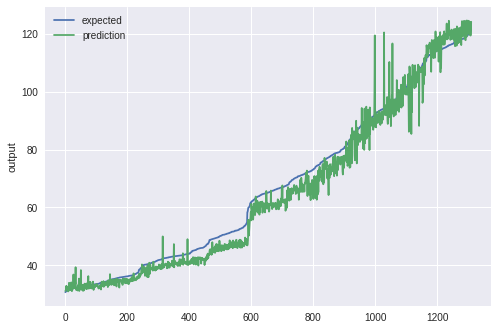

In [0]:
pred = [x for [x] in pred1]
chart_regression(pred,y_test)

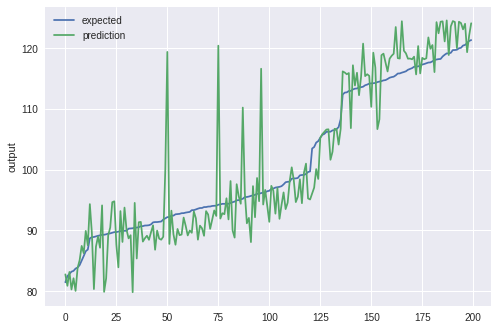

In [0]:
chart_regression(pred[1000:1200],y_test[1000:1200])

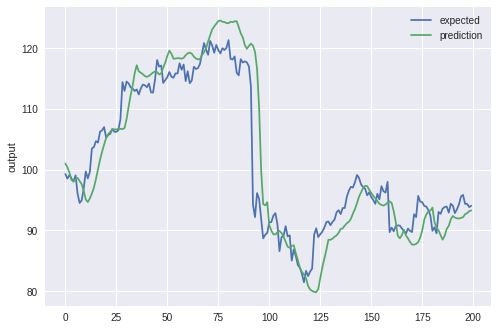

In [0]:
chart_regression(pred[1000:1200],y_test[1000:1200],sort=False)

#Task 3 : CNN

In [0]:
import numpy as np

def CNN_to_sequences(SEQUENCE_SIZE, data, col):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = col[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
     
        
    return np.array(x),np.array(y)

In [0]:
SEQUENCE_SIZE = 7
x_train1,y_train1 = CNN_to_sequences(SEQUENCE_SIZE,df_train,df_y_train)
x_test1,y_test1 = CNN_to_sequences(SEQUENCE_SIZE,df_test,df_y_test)
print(x_train1.shape,y_train1.shape)
print(x_test1.shape,y_test1.shape)

(3066, 7, 1, 5) (3066,)
(1310, 7, 1, 5) (1310,)


In [0]:

x_train1 = x_train.reshape(x_train.shape[0],1,SEQUENCE_SIZE,5)
x_test1 = x_test.reshape(x_test.shape[0],1,SEQUENCE_SIZE,5)
print(x_train1.shape,y_train1.shape)
print(x_test1.shape,y_test1.shape)

(3066, 1, 7, 5) (3066,)
(1310, 1, 7, 5) (1310,)


In [0]:
x_train1[0:5]

array([[[[-8.94208763e-01, -8.85021698e-01, -8.92306409e-01,
           4.12500000e+00,  1.10481203e+00],
         [-8.83762414e-01, -8.86056090e-01, -8.85975321e-01,
           4.01562500e+00, -4.97300682e-01],
         [-8.87940954e-01, -8.89159267e-01, -8.87558093e-01,
           4.00000000e+00, -8.92217148e-01],
         [-8.87940954e-01, -8.90193659e-01, -8.91251228e-01,
           3.84375000e+00, -2.63405247e-04],
         [-8.96820350e-01, -8.98985994e-01, -9.06551358e-01,
           3.39062500e+00,  3.72936618e+00],
         [-9.04655112e-01, -9.00020387e-01, -9.04968586e-01,
           3.43750000e+00,  5.92175691e+00],
         [-9.03610477e-01, -9.04157956e-01, -9.16575581e-01,
           3.50000000e+00,  6.93926498e+00]]],


       [[[-8.83762414e-01, -8.86056090e-01, -8.85975321e-01,
           4.01562500e+00, -4.97300682e-01],
         [-8.87940954e-01, -8.89159267e-01, -8.87558093e-01,
           4.00000000e+00, -8.92217148e-01],
         [-8.87940954e-01, -8.90193659e-01

In [0]:
y_train1[0:5]

array([3.484375, 3.578125, 3.609375, 3.640625, 3.578125], dtype=float32)

## Model variatons 

In [0]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
import time
import keras

In [0]:
# define a CNN

cnn = Sequential()
cnn.add(Conv2D(64, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=(1, 7, 5)))

# the above code is equivalent to 
# model.add(Conv1D(64, kernel_size=3, strides=1, activation='relu', input_shape=(128, 1)))

cnn.add(MaxPooling2D(pool_size=(1,1)))

cnn.add(Conv2D(128, kernel_size=(1, 1), strides=(1, 1),
                 activation='relu'))
cnn.add(MaxPooling2D(pool_size=(1,1)))
    
    
cnn.add(Flatten())
cnn.add(Dense(1024, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(1))

# define optimizer and objective, compile cnn

cnn.compile(loss="mean_squared_error", optimizer="adam")
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 5, 64)          1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 5, 128)         8320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 5, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 1024)              656384    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
__________

In [0]:
optimizer = ['SGD', 'Adagrad', 'Adam', 'Adamax']
for each in optimizer:
  SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

  start_time = time.time()
  checkpointer = ModelCheckpoint(filepath="cnn_project4.hdf5", verbose=0, save_best_only=True) # save best model
  for i in range(1):
  
    print(i)
  
    cnn.compile(loss=keras.losses.mean_squared_error, optimizer=each)


    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    cnn.fit(x_train1, y_train1,     
            batch_size=128,
            epochs=100,
            verbose=2,
            callbacks=[monitor],
            validation_data=(x_test1, y_test1))
   
    pred2 = cnn.predict(x_test1)
    score = np.sqrt(metrics.mean_squared_error(pred2,y_test1))
    print("(RMSE): {}".format(score))
    print(each,"ends")
  print('Training finished...Loading the best model')  
  print()
  elapsed_time = time.time() - start_time
  print("Elapsed time: {}".format(hms_string(elapsed_time)))
          
  cnn.save(os.path.join(save_path,"cnn_project4.hdf5"))         

0
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 18s - loss: 228.6546 - val_loss: 4636.6196
Epoch 2/100
 - 0s - loss: 67.8364 - val_loss: 278.7800
Epoch 3/100
 - 0s - loss: 21.7703 - val_loss: 1989.9476
Epoch 4/100
 - 0s - loss: 15.5485 - val_loss: 20.5234
Epoch 5/100
 - 0s - loss: 10.1503 - val_loss: 145.9524
Epoch 6/100
 - 0s - loss: 11.8399 - val_loss: 59.9566
Epoch 7/100
 - 0s - loss: 6.2630 - val_loss: 12.3329
Epoch 8/100
 - 0s - loss: 10.2113 - val_loss: 258.3109
Epoch 9/100
 - 0s - loss: 10.1203 - val_loss: 289.2798
Epoch 10/100
 - 0s - loss: 5.4744 - val_loss: 16.3623
Epoch 11/100
 - 0s - loss: 6.3451 - val_loss: 112.3254
Epoch 12/100
 - 0s - loss: 7.7420 - val_loss: 415.6725
Epoch 00012: early stopping
(RMSE): 20.38804817199707
SGD ends
Training finished...Loading the best model

Elapsed time: 0:00:27.03
0
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 17s - loss: 4.0933 - val_loss: 39.9289
Epoch 2/100
 - 0s - loss: 1.9089 - val_loss: 24.9730
Ep

In [0]:
# define a CNN

cnn = Sequential()
cnn.add(Conv2D(64, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=(1, 7, 5)))

# the above code is equivalent to 
# model.add(Conv1D(64, kernel_size=3, strides=1, activation='relu', input_shape=(128, 1)))

cnn.add(MaxPooling2D(pool_size=(1,1)))

cnn.add(Conv2D(128, kernel_size=(1, 1), strides=(1, 1),
                 activation='relu'))
cnn.add(MaxPooling2D(pool_size=(1,1)))
    
    
cnn.add(Flatten())
cnn.add(Dense(1024, activation="relu"))
#cnn.add(Dropout(0.5))
cnn.add(Dense(1))

# define optimizer and objective, compile cnn

cnn.compile(loss="mean_squared_error", optimizer="adam")
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 1, 5, 64)          1024      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 1, 5, 64)          0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 1, 5, 128)         8320      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 1, 5, 128)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 1024)              656384    
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 1025      
Total para

In [0]:
optimizer = ['Adagrad', 'Adam', 'Adamax']
for each in optimizer:
  SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

  start_time = time.time()
  checkpointer = ModelCheckpoint(filepath="cnn_project4.hdf5", verbose=0, save_best_only=True) # save best model
  for i in range(2):
  
    print(i)
  
    cnn.compile(loss=keras.losses.mean_squared_error, optimizer=each)


    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    cnn.fit(x_train1, y_train1,     
            batch_size=128,
            epochs=100,
            verbose=2,
            callbacks=[monitor],
            validation_data=(x_test1, y_test1))
   
    pred2 = cnn.predict(x_test1)
    score = np.sqrt(metrics.mean_squared_error(pred2,y_test1))
    print("(RMSE): {}".format(score))
    print(each,"ends")
  print('Training finished...Loading the best model')  
  print()
  elapsed_time = time.time() - start_time
  print("Elapsed time: {}".format(hms_string(elapsed_time)))
          
  cnn.save(os.path.join(save_path,"cnn_project4.hdf5"))         

0
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 20s - loss: 72.7699 - val_loss: 917.3124
Epoch 2/100
 - 0s - loss: 13.2101 - val_loss: 653.1952
Epoch 3/100
 - 0s - loss: 4.3231 - val_loss: 290.7940
Epoch 4/100
 - 0s - loss: 2.3577 - val_loss: 221.5576
Epoch 5/100
 - 0s - loss: 1.7206 - val_loss: 145.5261
Epoch 6/100
 - 0s - loss: 1.4851 - val_loss: 146.1122
Epoch 7/100
 - 0s - loss: 0.9563 - val_loss: 80.0186
Epoch 8/100
 - 0s - loss: 0.7148 - val_loss: 91.9564
Epoch 9/100
 - 0s - loss: 0.9385 - val_loss: 90.0864
Epoch 10/100
 - 0s - loss: 0.5475 - val_loss: 79.5561
Epoch 11/100
 - 0s - loss: 0.7503 - val_loss: 85.5846
Epoch 12/100
 - 0s - loss: 0.4982 - val_loss: 85.4867
Epoch 13/100
 - 0s - loss: 0.4423 - val_loss: 62.0036
Epoch 14/100
 - 0s - loss: 0.7237 - val_loss: 79.2058
Epoch 15/100
 - 0s - loss: 0.5099 - val_loss: 59.1453
Epoch 16/100
 - 0s - loss: 0.4384 - val_loss: 71.6985
Epoch 17/100
 - 0s - loss: 0.4965 - val_loss: 62.8590
Epoch 18/100
 - 0s - loss: 0.413

In [0]:
# define a CNN

cnn = Sequential()
cnn.add(Conv2D(64, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=(1, 7, 5)))

# the above code is equivalent to 
# model.add(Conv1D(64, kernel_size=3, strides=1, activation='relu', input_shape=(128, 1)))

cnn.add(MaxPooling2D(pool_size=(1,1)))

cnn.add(Conv2D(128, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu'))
cnn.add(MaxPooling2D(pool_size=(1,1)))
    
    
cnn.add(Flatten())
cnn.add(Dense(1024, activation="relu"))
#cnn.add(Dropout(0.5))
cnn.add(Dense(1))

# define optimizer and objective, compile cnn

cnn.compile(loss="mean_squared_error", optimizer="adam")
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 1, 5, 64)          1024      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 1, 5, 64)          0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 1, 3, 128)         24704     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 1, 3, 128)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 384)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 1024)              394240    
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 1025      
Total para

In [0]:
optimizer = ['Adamax']
for each in optimizer:
  SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

  start_time = time.time()
  checkpointer = ModelCheckpoint(filepath="cnn_project4.hdf5", verbose=0, save_best_only=True) # save best model
  for i in range(5):
  
    print(i)
  
    cnn.compile(loss=keras.losses.mean_squared_error, optimizer=each)


    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    cnn.fit(x_train1, y_train1,     
            batch_size=128,
            epochs=100,
            verbose=2,
            callbacks=[monitor],
            validation_data=(x_test1, y_test1))
   
    pred2 = cnn.predict(x_test1)
    score = np.sqrt(metrics.mean_squared_error(pred2,y_test1))
    print("(RMSE): {}".format(score))
    print(each,"ends")
  print('Training finished...Loading the best model')  
  print()
  elapsed_time = time.time() - start_time
  print("Elapsed time: {}".format(hms_string(elapsed_time)))
          
  cnn.save(os.path.join(save_path,"cnn_project4.hdf5"))         

0
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 22s - loss: 166.7976 - val_loss: 9951.0995
Epoch 2/100
 - 0s - loss: 58.2507 - val_loss: 3095.2119
Epoch 3/100
 - 0s - loss: 39.1793 - val_loss: 2129.9000
Epoch 4/100
 - 0s - loss: 26.7602 - val_loss: 1034.0469
Epoch 5/100
 - 0s - loss: 16.1489 - val_loss: 791.0825
Epoch 6/100
 - 0s - loss: 7.7326 - val_loss: 196.2881
Epoch 7/100
 - 0s - loss: 2.9737 - val_loss: 69.1360
Epoch 8/100
 - 0s - loss: 1.3559 - val_loss: 33.2010
Epoch 9/100
 - 0s - loss: 0.9543 - val_loss: 35.0161
Epoch 10/100
 - 0s - loss: 0.8101 - val_loss: 30.9658
Epoch 11/100
 - 0s - loss: 0.7097 - val_loss: 27.2224
Epoch 12/100
 - 0s - loss: 0.6507 - val_loss: 21.3990
Epoch 13/100
 - 0s - loss: 0.5925 - val_loss: 22.6675
Epoch 14/100
 - 0s - loss: 0.5531 - val_loss: 22.8096
Epoch 15/100
 - 0s - loss: 0.5457 - val_loss: 18.3891
Epoch 16/100
 - 0s - loss: 0.5008 - val_loss: 13.5892
Epoch 17/100
 - 0s - loss: 0.4960 - val_loss: 18.3508
Epoch 18/100
 - 0s - los

In [0]:
# define a CNN

cnn = Sequential()
cnn.add(Conv2D(128, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=(1, 7, 5)))

# the above code is equivalent to 
# model.add(Conv1D(64, kernel_size=3, strides=1, activation='relu', input_shape=(128, 1)))

cnn.add(MaxPooling2D(pool_size=(1,1)))

cnn.add(Conv2D(264, kernel_size=(1, 1), strides=(1, 1),
                 activation='relu'))
cnn.add(MaxPooling2D(pool_size=(1,1)))
    
    
cnn.add(Flatten())
cnn.add(Dense(1024, activation="relu"))
#cnn.add(Dropout(0.5))
cnn.add(Dense(1))

# define optimizer and objective, compile cnn

cnn.compile(loss="mean_squared_error", optimizer="adam")
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 1, 5, 128)         2048      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 1, 5, 128)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 1, 5, 264)         34056     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 1, 5, 264)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 1320)              0         
_________________________________________________________________
dense_66 (Dense)             (None, 1024)              1352704   
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 1025      
Total para

In [0]:
optimizer = ['Adamax']
for each in optimizer:
  SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

  start_time = time.time()
  checkpointer = ModelCheckpoint(filepath="cnn_project4.hdf5", verbose=0, save_best_only=True) # save best model
  for i in range(3):
  
    print(i)
  
    cnn.compile(loss=keras.losses.mean_squared_error, optimizer=each)


    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    cnn.fit(x_train1, y_train1,     
            batch_size=128,
            epochs=100,
            verbose=2,
            callbacks=[monitor],
            validation_data=(x_test1, y_test1))
   
    pred2 = cnn.predict(x_test1)
    score = np.sqrt(metrics.mean_squared_error(pred2,y_test1))
    print("(RMSE): {}".format(score))
    print(each,"ends")
  print('Training finished...Loading the best model')  
  print()
  elapsed_time = time.time() - start_time
  print("Elapsed time: {}".format(hms_string(elapsed_time)))
          
  cnn.save(os.path.join(save_path,"cnn_project4.hdf5"))         

0
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 22s - loss: 130.7584 - val_loss: 6022.7435
Epoch 2/100
 - 0s - loss: 41.4514 - val_loss: 2330.0811
Epoch 3/100
 - 0s - loss: 19.7296 - val_loss: 850.2185
Epoch 4/100
 - 0s - loss: 6.5687 - val_loss: 258.9538
Epoch 5/100
 - 0s - loss: 1.8067 - val_loss: 142.4930
Epoch 6/100
 - 0s - loss: 0.9568 - val_loss: 163.5819
Epoch 7/100
 - 0s - loss: 0.7626 - val_loss: 144.3834
Epoch 8/100
 - 0s - loss: 0.6404 - val_loss: 119.9278
Epoch 9/100
 - 0s - loss: 0.5547 - val_loss: 109.5641
Epoch 10/100
 - 0s - loss: 0.5141 - val_loss: 99.3716
Epoch 11/100
 - 0s - loss: 0.4893 - val_loss: 101.0764
Epoch 12/100
 - 0s - loss: 0.4585 - val_loss: 112.3880
Epoch 13/100
 - 0s - loss: 0.4306 - val_loss: 91.4465
Epoch 14/100
 - 0s - loss: 0.4115 - val_loss: 99.8490
Epoch 15/100
 - 0s - loss: 0.3938 - val_loss: 101.0351
Epoch 16/100
 - 0s - loss: 0.3750 - val_loss: 88.4983
Epoch 17/100
 - 0s - loss: 0.3723 - val_loss: 97.6165
Epoch 18/100
 - 0s - l

In [0]:
# define a CNN

cnn = Sequential()
cnn.add(Conv2D(128, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=(1, 7, 5)))

# the above code is equivalent to 
# model.add(Conv1D(64, kernel_size=3, strides=1, activation='relu', input_shape=(128, 1)))

cnn.add(MaxPooling2D(pool_size=(1,1)))

cnn.add(Conv2D(64, kernel_size=(1, 1), strides=(1, 1),
                 activation='relu'))
cnn.add(MaxPooling2D(pool_size=(1,1)))
    
    
cnn.add(Flatten())
cnn.add(Dense(1024, activation="relu"))
#cnn.add(Dropout(0.5))
cnn.add(Dense(1))

# define optimizer and objective, compile cnn

cnn.compile(loss="mean_squared_error", optimizer="adam")
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 1, 5, 128)         2048      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 1, 5, 128)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 1, 5, 64)          8256      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 1, 5, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 1024)              328704    
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 1025      
Total para

In [0]:
optimizer = ['Adagrad', 'Adam', 'Adamax']
for each in optimizer:
  SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

  start_time = time.time()
  checkpointer = ModelCheckpoint(filepath="cnn_project4.hdf5", verbose=0, save_best_only=True) # save best model
  for i in range(2):
  
    print(i)
  
    cnn.compile(loss=keras.losses.mean_squared_error, optimizer=each)


    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    cnn.fit(x_train1, y_train1,     
            batch_size=128,
            epochs=100,
            verbose=2,
            callbacks=[monitor],
            validation_data=(x_test1, y_test1))
   
    pred2 = cnn.predict(x_test1)
    score = np.sqrt(metrics.mean_squared_error(pred2,y_test1))
    print("(RMSE): {}".format(score))
    print(each,"ends")
  print('Training finished...Loading the best model')  
  print()
  elapsed_time = time.time() - start_time
  print("Elapsed time: {}".format(hms_string(elapsed_time)))
          
  cnn.save(os.path.join(save_path,"cnn_project4.hdf5"))         

0
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 20s - loss: 95.6885 - val_loss: 1976.7062
Epoch 2/100
 - 0s - loss: 19.4710 - val_loss: 481.1405
Epoch 3/100
 - 0s - loss: 7.9118 - val_loss: 232.7655
Epoch 4/100
 - 0s - loss: 3.4927 - val_loss: 150.7366
Epoch 5/100
 - 0s - loss: 2.5830 - val_loss: 183.2033
Epoch 6/100
 - 0s - loss: 2.4233 - val_loss: 187.8922
Epoch 7/100
 - 0s - loss: 1.8762 - val_loss: 163.8284
Epoch 8/100
 - 0s - loss: 1.1506 - val_loss: 110.9438
Epoch 9/100
 - 0s - loss: 0.9777 - val_loss: 142.6518
Epoch 10/100
 - 0s - loss: 1.1858 - val_loss: 146.1996
Epoch 11/100
 - 0s - loss: 0.7055 - val_loss: 113.4177
Epoch 12/100
 - 0s - loss: 0.6780 - val_loss: 179.5081
Epoch 13/100
 - 0s - loss: 0.8457 - val_loss: 147.8007
Epoch 00013: early stopping
(RMSE): 12.157332420349121
Adagrad ends
1
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 20s - loss: 33.8634 - val_loss: 17.8923
Epoch 2/100
 - 0s - loss: 2.5728 - val_loss: 44.2087
Epoch 3/100
 -

In [0]:
# define a CNN


cnn1 = Sequential()
cnn1.add(Conv2D(48, kernel_size=(1, 2), strides=(1, 1),
                 activation='sigmoid',
                 input_shape=(1, 7, 5)))

# the above code is equivalent to 
# model.add(Conv1D(64, kernel_size=3, strides=1, activation='relu', input_shape=(128, 1)))

cnn1.add(MaxPooling2D(pool_size=(1,2)))

cnn1.add(Conv2D(82, kernel_size=(1,2), strides=(1, 1),
                 activation='sigmoid'))
cnn1.add(MaxPooling2D(pool_size=(1,2)))
    
    
cnn1.add(Flatten())
cnn1.add(Dense(1024, activation="sigmoid"))
cnn1.add(Dropout(0.5))
cnn1.add(Dense(1))

# define optimizer and objective, compile cnn

cnn1.compile(loss="mean_squared_error", optimizer="adam")
cnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 1, 6, 48)          528       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 3, 48)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 2, 82)          7954      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 82)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 82)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 1024)              84992     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
__________

In [0]:
optimizer = ['SGD', 'Adagrad', 'Adam', 'Adamax']
for each in optimizer:
  #SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

  start_time = time.time()
  checkpointer = ModelCheckpoint(filepath="cnn_project4.hdf5", verbose=0, save_best_only=True) # save best model
  for i in range(1):
  
    print(i)
  
    cnn1.compile(loss=keras.losses.mean_squared_error, optimizer=each)


    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    cnn1.fit(x_train1, y_train1,     
            batch_size=128,
            epochs=100,
            verbose=2,
            callbacks=[monitor],
            validation_data=(x_test1, y_test1))
   
    pred2 = cnn1.predict(x_test1)
    score = np.sqrt(metrics.mean_squared_error(pred2,y_test1))
    print("(RMSE): {}".format(score))
    print(each,"ends")
  print('Training finished...Loading the best model')  
  print()
  elapsed_time = time.time() - start_time
  print("Elapsed time: {}".format(hms_string(elapsed_time)))
          
  cnn1.save(os.path.join(save_path,"cnn_project4.hdf5"))         

0
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 18s - loss: 1619.8791 - val_loss: 4455.8561
Epoch 2/100
 - 0s - loss: 164.2482 - val_loss: 4084.6548
Epoch 3/100
 - 0s - loss: 137.1825 - val_loss: 3866.1874
Epoch 4/100
 - 0s - loss: 126.9282 - val_loss: 3736.2393
Epoch 5/100
 - 0s - loss: 123.0295 - val_loss: 3655.4560
Epoch 6/100
 - 0s - loss: 121.4989 - val_loss: 3605.3640
Epoch 7/100
 - 0s - loss: 120.9429 - val_loss: 3577.5187
Epoch 8/100
 - 0s - loss: 120.7426 - val_loss: 3560.7146
Epoch 9/100
 - 0s - loss: 120.6633 - val_loss: 3547.0379
Epoch 10/100
 - 0s - loss: 120.6344 - val_loss: 3539.4231
Epoch 11/100
 - 0s - loss: 120.6211 - val_loss: 3534.8255
Epoch 12/100
 - 0s - loss: 120.6171 - val_loss: 3532.3075
Epoch 13/100
 - 0s - loss: 120.6124 - val_loss: 3531.9184
Epoch 14/100
 - 0s - loss: 120.6280 - val_loss: 3531.0381
Epoch 15/100
 - 0s - loss: 120.6216 - val_loss: 3532.6585
Epoch 16/100
 - 0s - loss: 120.6169 - val_loss: 3532.6055
Epoch 17/100
 - 0s - loss: 12

In [0]:
# define a CNN


cnn2 = Sequential()
cnn2.add(Conv2D(256, kernel_size=(1, 5), strides=(1, 1),
                 activation='tanh',
                 input_shape=(1, 7, 5)))

# the above code is equivalent to 
# model.add(Conv1D(64, kernel_size=3, strides=1, activation='relu', input_shape=(128, 1)))

#cnn2.add(MaxPooling2D(pool_size=(1,1)))

cnn2.add(Conv2D(64, kernel_size=(1, 1), strides=(1, 1), activation='tanh'))
#cnn2.add(MaxPooling2D(pool_size=(1,1)))

    
cnn2.add(Flatten())
cnn2.add(Dense(1024, activation="tanh"))
cnn2.add(Dropout(0.5))
cnn2.add(Dense(1))

# define optimizer and objective, compile cnn

cnn2.compile(loss="mean_squared_error", optimizer="adam")
cnn2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 1, 3, 256)         6656      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 1, 3, 64)          16448     
_________________________________________________________________
flatten_6 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 1024)              197632    
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 1025      
Total params: 221,761
Trainable params: 221,761
Non-trainable params: 0
_________________________________________________________________


In [0]:

optimizer = [ 'Adagrad', 'Adam', 'Adamax']
for each in optimizer:
  #SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

  start_time = time.time()
  checkpointer = ModelCheckpoint(filepath="cnn_project4.hdf5", verbose=0, save_best_only=True) # save best model
  for i in range(1):
  
    print(i)
  
    cnn2.compile(loss=keras.losses.mean_squared_error, optimizer=each)


    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    cnn2.fit(x_train1, y_train1,     
            batch_size=128,
            epochs=100,
            verbose=2,
            callbacks=[monitor],
            validation_data=(x_test1, y_test1))
   
    pred2 = cnn2.predict(x_test1)
    score = np.sqrt(metrics.mean_squared_error(pred2,y_test1))
    print("(RMSE): {}".format(score))
    print(each,"ends")
  print('Training finished...Loading the best model')  
  print()
  elapsed_time = time.time() - start_time
  print("Elapsed time: {}".format(hms_string(elapsed_time)))
          
  cnn2.save(os.path.join(save_path,"cnn_project4.hdf5"))         

0
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 19s - loss: 231.9387 - val_loss: 2859.8345
Epoch 2/100
 - 0s - loss: 54.4270 - val_loss: 1961.8081
Epoch 3/100
 - 0s - loss: 14.8690 - val_loss: 1605.9954
Epoch 4/100
 - 0s - loss: 4.9445 - val_loss: 1475.9902
Epoch 5/100
 - 0s - loss: 4.5579 - val_loss: 1451.1007
Epoch 6/100
 - 0s - loss: 3.4074 - val_loss: 1408.2954
Epoch 7/100
 - 0s - loss: 2.7325 - val_loss: 1385.1663
Epoch 8/100
 - 0s - loss: 3.2351 - val_loss: 1367.7409
Epoch 9/100
 - 0s - loss: 2.6231 - val_loss: 1343.8485
Epoch 10/100
 - 0s - loss: 2.4418 - val_loss: 1320.8908
Epoch 11/100
 - 0s - loss: 2.5192 - val_loss: 1305.1828
Epoch 12/100
 - 0s - loss: 4.0920 - val_loss: 1295.5344
Epoch 13/100
 - 0s - loss: 3.1493 - val_loss: 1282.0642
Epoch 14/100
 - 0s - loss: 2.1642 - val_loss: 1259.7220
Epoch 15/100
 - 0s - loss: 2.0613 - val_loss: 1258.5605
Epoch 16/100
 - 0s - loss: 3.2984 - val_loss: 1241.7514
Epoch 17/100
 - 0s - loss: 2.8433 - val_loss: 1232.4938
Ep

In [0]:
#old is gold

In [0]:
# define a CNN


cnn3 = Sequential()
cnn3.add(Conv2D(128, kernel_size=(1,3), strides=(1, 1),
                 activation='sigmoid',
                 input_shape=(1, 7, 5)))

# the above code is equivalent to 


cnn3.add(MaxPooling2D(pool_size=(1,1)))

cnn3.add(Conv2D(256, kernel_size=(1,1), strides=(1, 1),
                 activation='sigmoid'))
cnn3.add(MaxPooling2D(pool_size=(1,1)))

cnn3.add(Dropout(0.5))   
    
cnn3.add(Flatten())
cnn3.add(Dense(2000, activation="relu"))
cnn3.add(Dropout(0.5))
cnn3.add(Dense(1))

# define optimizer and objective, compile cnn

cnn3.compile(loss="mean_squared_error", optimizer="adam")
cnn3.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 5, 128)         2048      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 5, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 5, 256)         33024     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 5, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 5, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)  

In [0]:
optimizer = ['SGD', 'Adagrad', 'Adam', 'Adamax']
for each in optimizer:
  SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

  start_time = time.time()
  checkpointer = ModelCheckpoint(filepath="cnn_project4.hdf5", verbose=0, save_best_only=True) # save best model
  for i in range(1):
  
    print(i)
  
    cnn3.compile(loss=keras.losses.mean_squared_error, optimizer=each)


    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    cnn3.fit(x_train1, y_train1,     
            batch_size=128,
            epochs=100,
            verbose=2,
            callbacks=[monitor],
            validation_data=(x_test1, y_test1))
   
    pred2 = cnn3.predict(x_test1)
    score = np.sqrt(metrics.mean_squared_error(pred2,y_test1))
    print("(RMSE): {}".format(score))
    print(each,"ends")
  print('Training finished...Loading the best model')  
  print()
  elapsed_time = time.time() - start_time
  print("Elapsed time: {}".format(hms_string(elapsed_time)))
          
  cnn3.save(os.path.join(save_path,"cnn_project4.hdf5"))         

0
Instructions for updating:
Use tf.cast instead.
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 7s - loss: 1627.7795 - val_loss: 3602.6718
Epoch 2/100
 - 0s - loss: 140.9127 - val_loss: 3626.4414
Epoch 3/100
 - 0s - loss: 132.4492 - val_loss: 3709.8317
Epoch 4/100
 - 0s - loss: 134.1085 - val_loss: 3603.4256
Epoch 5/100
 - 0s - loss: 129.6188 - val_loss: 3671.3290
Epoch 6/100
 - 0s - loss: 130.4658 - val_loss: 3712.1604
Epoch 00006: early stopping
(RMSE): 60.9275016784668
SGD ends
Training finished...Loading the best model

Elapsed time: 0:00:09.20
0
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 1s - loss: 118.5651 - val_loss: 3537.3302
Epoch 2/100
 - 0s - loss: 93.5094 - val_loss: 3366.7415
Epoch 3/100
 - 0s - loss: 81.4254 - val_loss: 3236.1586
Epoch 4/100
 - 0s - loss: 70.1073 - val_loss: 3123.7667
Epoch 5/100
 - 0s - loss: 63.7230 - val_loss: 3020.4031
Epoch 6/100
 - 0s - loss: 56.6125 - val_loss: 2931.4823
Epoch 7/100
 - 0s - loss: 49.2994 - val_l

##best model

In [0]:
# define a CNN

cnn = Sequential()
cnn.add(Conv2D(64, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=(1, 7, 5)))

# the above code is equivalent to 
# model.add(Conv1D(64, kernel_size=3, strides=1, activation='relu', input_shape=(128, 1)))

cnn.add(MaxPooling2D(pool_size=(1,1)))

cnn.add(Conv2D(128, kernel_size=(1, 1), strides=(1, 1),
                 activation='relu'))
cnn.add(MaxPooling2D(pool_size=(1,1)))
    
    
cnn.add(Flatten())
cnn.add(Dense(1024, activation="relu"))
#cnn.add(Dropout(0.5))
cnn.add(Dense(1))

# define optimizer and objective, compile cnn

cnn.compile(loss="mean_squared_error", optimizer="adam")
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 1, 5, 64)          1024      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 5, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 5, 128)         8320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 5, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              656384    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1025      
Total para

In [0]:
optimizer = ['Adamax']
for each in optimizer:
  SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

  start_time = time.time()
  checkpointer = ModelCheckpoint(filepath="cnn_project4.hdf5", verbose=0, save_best_only=True) # save best model
  for i in range(5):
  
    print(i)
  
    cnn.compile(loss=keras.losses.mean_squared_error, optimizer=each)


    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    cnn.fit(x_train1, y_train1,     
            batch_size=128,
            epochs=100,
            verbose=2,
            callbacks=[monitor],
            validation_data=(x_test1, y_test1))
   
    pred2 = cnn.predict(x_test1)
    score = np.sqrt(metrics.mean_squared_error(pred2,y_test1))
    print("(RMSE): {}".format(score))
    print(each,"ends")
  print('Training finished...Loading the best model')  
  print()
  elapsed_time = time.time() - start_time
  print("Elapsed time: {}".format(hms_string(elapsed_time)))
          
  cnn.save(os.path.join(save_path,"cnn_project4.hdf5"))         

0
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 23s - loss: 5.4562 - val_loss: 22.9791
Epoch 2/100
 - 0s - loss: 0.6184 - val_loss: 32.3218
Epoch 3/100
 - 0s - loss: 0.3131 - val_loss: 29.4312
Epoch 4/100
 - 0s - loss: 0.2857 - val_loss: 37.2260
Epoch 5/100
 - 0s - loss: 0.2743 - val_loss: 42.6479
Epoch 6/100
 - 0s - loss: 0.2669 - val_loss: 44.4611
Epoch 00006: early stopping
(RMSE): 6.667914390563965
Adamax ends
1
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 24s - loss: 2.2275 - val_loss: 9.0855
Epoch 2/100
 - 0s - loss: 0.3731 - val_loss: 14.0342
Epoch 3/100
 - 0s - loss: 0.2774 - val_loss: 16.7319
Epoch 4/100
 - 0s - loss: 0.2589 - val_loss: 17.4970
Epoch 5/100
 - 0s - loss: 0.2509 - val_loss: 18.4614
Epoch 6/100
 - 0s - loss: 0.2539 - val_loss: 25.5661
Epoch 00006: early stopping
(RMSE): 5.056291580200195
Adamax ends
2
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 24s - loss: 4.1276 - val_loss: 16.8117
Epoch 2/100
 - 0s - loss: 0

In [0]:
optimizer = ['Adamax']
for each in optimizer:
  SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

  start_time = time.time()
  checkpointer = ModelCheckpoint(filepath="cnn_project4_1.hdf5", verbose=0, save_best_only=True) # save best model
  for i in range(10):
  
    print(i)
  
    cnn.compile(loss=keras.losses.mean_squared_error, optimizer=each)


    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    cnn.fit(x_train1, y_train1,     
            batch_size=128,
            epochs=100,
            verbose=2,
            callbacks=[monitor],
            validation_data=(x_test1, y_test1))
   
    pred2 = cnn.predict(x_test1)
    score = np.sqrt(metrics.mean_squared_error(pred2,y_test1))
    print("(RMSE): {}".format(score))
    print(each,"ends")
  print('Training finished...Loading the best model')  
  print()
  elapsed_time = time.time() - start_time
  print("Elapsed time: {}".format(hms_string(elapsed_time)))
          
  #cnn.save(os.path.join(save_path,"cnn_project4_1.hdf5"))         

0
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 24s - loss: 3.8900 - val_loss: 7.1640
Epoch 2/100
 - 0s - loss: 0.5539 - val_loss: 6.1852
Epoch 3/100
 - 0s - loss: 0.2787 - val_loss: 4.2890
Epoch 4/100
 - 0s - loss: 0.2492 - val_loss: 4.3054
Epoch 5/100
 - 0s - loss: 0.2331 - val_loss: 4.2270
Epoch 6/100
 - 0s - loss: 0.2275 - val_loss: 4.5455
Epoch 7/100
 - 0s - loss: 0.2238 - val_loss: 4.3130
Epoch 8/100
 - 0s - loss: 0.2183 - val_loss: 5.1583
Epoch 9/100
 - 0s - loss: 0.2147 - val_loss: 4.4171
Epoch 10/100
 - 0s - loss: 0.2161 - val_loss: 4.5900
Epoch 00010: early stopping
(RMSE): 2.142428159713745
Adamax ends
1
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 24s - loss: 1.4959 - val_loss: 8.9301
Epoch 2/100
 - 0s - loss: 0.3526 - val_loss: 4.8535
Epoch 3/100
 - 0s - loss: 0.2525 - val_loss: 3.9826
Epoch 4/100
 - 0s - loss: 0.2212 - val_loss: 3.9906
Epoch 5/100
 - 0s - loss: 0.2130 - val_loss: 4.2719
Epoch 6/100
 - 0s - loss: 0.2116 - val_loss: 4.0183

In [0]:
optimizer = ['Adamax']
for each in optimizer:
  SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

  start_time = time.time()
  checkpointer = ModelCheckpoint(filepath="cnn_project4_b1.hdf5", verbose=0, save_best_only=True) # save best model
  for i in range(15):
  
    print(i)
  
    cnn.compile(loss=keras.losses.mean_squared_error, optimizer=each)


    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    cnn.fit(x_train1, y_train1,     
            batch_size=128,
            epochs=100,
            verbose=2,
            callbacks=[monitor],
            validation_data=(x_test1, y_test1))
   
    pred2 = cnn.predict(x_test1)
    score = np.sqrt(metrics.mean_squared_error(pred2,y_test1))
    print("(RMSE): {}".format(score))
    print(each,"ends")
  print('Training finished...Loading the best model')  
  print()
  elapsed_time = time.time() - start_time
  print("Elapsed time: {}".format(hms_string(elapsed_time)))
          
  #cnn.save(os.path.join(save_path,"cnn_project4_1.hdf5"))         

0
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 1s - loss: 4.7864 - val_loss: 5.8467
Epoch 2/100
 - 0s - loss: 0.5245 - val_loss: 8.3944
Epoch 3/100
 - 0s - loss: 0.2526 - val_loss: 4.4450
Epoch 4/100
 - 0s - loss: 0.2070 - val_loss: 3.4945
Epoch 5/100
 - 0s - loss: 0.2009 - val_loss: 3.7217
Epoch 6/100
 - 0s - loss: 0.1962 - val_loss: 4.5189
Epoch 7/100
 - 0s - loss: 0.1942 - val_loss: 5.4683
Epoch 8/100
 - 0s - loss: 0.1930 - val_loss: 3.9677
Epoch 9/100
 - 0s - loss: 0.1877 - val_loss: 3.8910
Epoch 00009: early stopping
(RMSE): 1.9725550413131714
Adamax ends
1
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 1s - loss: 2.6437 - val_loss: 13.3093
Epoch 2/100
 - 0s - loss: 0.4082 - val_loss: 3.9604
Epoch 3/100
 - 0s - loss: 0.2595 - val_loss: 3.5438
Epoch 4/100
 - 0s - loss: 0.2092 - val_loss: 3.6799
Epoch 5/100
 - 0s - loss: 0.1968 - val_loss: 3.6573
Epoch 6/100
 - 0s - loss: 0.1896 - val_loss: 3.6847
Epoch 7/100
 - 0s - loss: 0.1842 - val_loss: 4.1261


In [0]:
#loading the best saved model
from keras.models import load_model
model1 = load_model(os.path.join(save_path,"cnn_project4_b1.hdf5"))
pred1 = model1.predict(x_test1)
print (pred1.shape)
# Measure RMSE error.  RMSE is common for regression.
cnns = np.sqrt(metrics.mean_squared_error(pred1,y_test1))
print("Predicted classes:",pred1[0:10])
print("Expected classes:",y_test1[0:10])
print("After load score (RMSE): {}".format(cnns))
cnnr2=metrics.r2_score(pred1,y_test)
print ("R2 score:",cnnr2)
#chart_regression(pred1[0:1],y_test01)

(1310, 1)
Predicted classes: [[50.595318]
 [50.902718]
 [50.638836]
 [50.931206]
 [50.6201  ]
 [51.178085]
 [51.51366 ]
 [51.498405]
 [51.59022 ]
 [51.589233]]
Expected classes: [51.075 50.74  50.91  50.59  51.65  52.105 51.975 52.22  50.96  51.67 ]
After load score (RMSE): 1.8140490055084229
R2 score: 0.9955348187206736


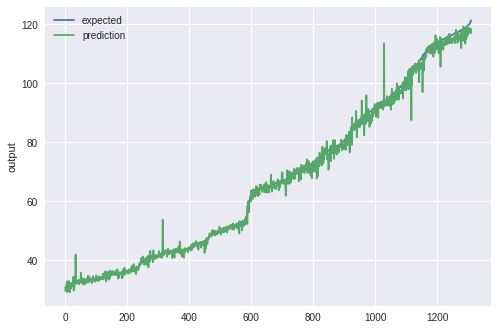

In [0]:
pred = [x for [x] in pred1]
chart_regression(pred,y_test1)

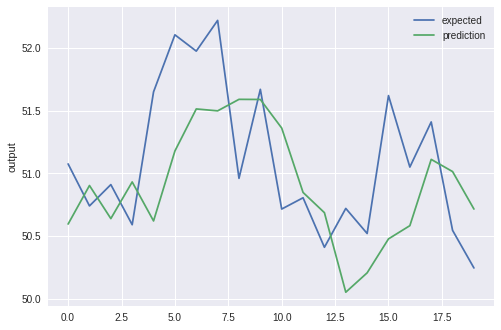

In [0]:
chart_regression(pred[0:20],y_test1[0:20],sort=False)

In [0]:
chart_regression(pred[0:20],y_test1[0:20])

#Comparison

In [0]:
best_nn = ['Nueral Network',fcnn]
best_lstm = ['LSTM',lstm]
best_cnn = ['CNN',cnns]
y_label = pd.DataFrame(data = np.array((best_nn,best_lstm,best_cnn), dtype=object),columns = ['Models','RMSE'])
y_label = y_label.set_index('Models')

Text(0, 0.5, 'RMSE')

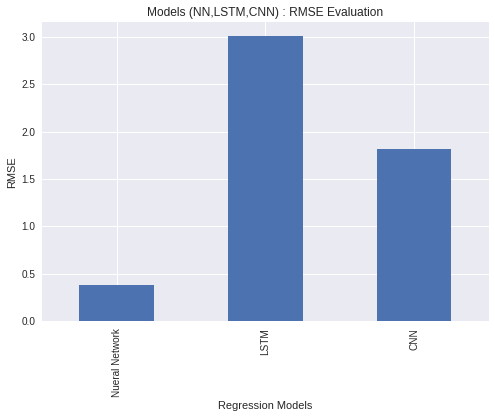

In [0]:
my_plot2 = y_label.plot(kind='bar',legend=None,title="Models (NN,LSTM,CNN) : RMSE Evaluation",)
my_plot2.set_xlabel("Regression Models")
my_plot2.set_ylabel("RMSE")

#Additional Feature

#1.Best value of N

##LSTM

In [0]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers
path = ""
save_path=""
from sklearn import metrics

In [0]:
def best_lstm_value(min_val,max_val):
  print('Build model...')
  RMSE=[]
  checkpointer = ModelCheckpoint(filepath="lstm_add_neural_project4.hdf5", verbose=0, save_best_only=True)
  Adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  for i in range(min_val,max_val+1):
  
    SEQUENCE_SIZE = i
    x_train,y_train = to_sequences(i,df_train,df_y_train)
    x_test,y_test = to_sequences(i,df_test,df_y_test)
    #print(x_test.shape)
    model = Sequential()
    # my best lstm model
    print(i)
    model = Sequential()
   
    model.add(LSTM(128, activation='relu',return_sequences=True,dropout=0.1, recurrent_dropout=0.1, input_shape=(i, 5)))

    model.add(LSTM(64, activation='relu', dropout=0.1,recurrent_dropout=0.1))
  
    #model.add(LSTM(128, activation='sigmoid', dropout=0.2, recurrent_dropout=0.2))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
              optimizer='Adam')


    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    pred = model.predict(x_test)
    score2 = np.sqrt(metrics.mean_squared_error(pred,y_test))
    RMSE.append(score2)
    print("(RMSE): {}".format(score2))
    print(i,"Completed")
  print(RMSE)
  value = []
  j=min_val
  for i in range(len(RMSE)):
    value.insert(i,[j,RMSE[i]])
    j = j+1
  n = pd.DataFrame(data = np.array((value), dtype=object),columns = ['N','RMSE'])
  return n,RMSE
  
  
#model.save(os.path.join(save_path,"lstm_add_neural_project4.hdf5"))

In [0]:
rmse_all,RMSE1 = best_lstm_value(6,7)

Build model...
(1311, 6, 5)
6
Train...
Train on 3067 samples, validate on 1311 samples
Epoch 1/100
 - 12s - loss: 471.6750 - val_loss: 808522.2583
Epoch 2/100
 - 4s - loss: 85.3065 - val_loss: 145161.0256
Epoch 3/100
 - 4s - loss: 35.6022 - val_loss: 43881.0114
Epoch 4/100
 - 4s - loss: 18.3690 - val_loss: 24972.8943
Epoch 5/100
 - 4s - loss: 14.3008 - val_loss: 12868.0295
Epoch 6/100
 - 4s - loss: 10.4433 - val_loss: 7593.6897
Epoch 7/100
 - 4s - loss: 8.4175 - val_loss: 6021.2333
Epoch 8/100
 - 4s - loss: 7.1473 - val_loss: 6767.9251
Epoch 9/100
 - 4s - loss: 6.4509 - val_loss: 6209.9782
Epoch 10/100
 - 4s - loss: 6.0175 - val_loss: 6428.4303
Epoch 11/100
 - 4s - loss: 5.3298 - val_loss: 6359.9314
Epoch 12/100
 - 4s - loss: 5.0267 - val_loss: 5494.6057
Epoch 13/100
 - 4s - loss: 4.2989 - val_loss: 4715.2375
Epoch 14/100
 - 4s - loss: 4.3193 - val_loss: 5099.5466
Epoch 15/100
 - 4s - loss: 3.7042 - val_loss: 4783.8765
Epoch 16/100
 - 4s - loss: 3.8870 - val_loss: 4946.4236
Epoch 17/10

In [0]:
rmse_all,RMSE1 = best_lstm_value(6,14)

Build model...
(1311, 6, 5)
6
Train...
Train on 3067 samples, validate on 1311 samples
Epoch 1/100
 - 13s - loss: 245.1470 - val_loss: 148918.5346
Epoch 2/100
 - 4s - loss: 179.1882 - val_loss: 7036.9094
Epoch 3/100
 - 4s - loss: 10.7403 - val_loss: 3177.3552
Epoch 4/100
 - 4s - loss: 8.1142 - val_loss: 3061.6076
Epoch 5/100
 - 4s - loss: 6.2300 - val_loss: 2621.9142
Epoch 6/100
 - 4s - loss: 5.2294 - val_loss: 1834.4066
Epoch 7/100
 - 4s - loss: 4.4722 - val_loss: 1747.2187
Epoch 8/100
 - 4s - loss: 4.3858 - val_loss: 1049.8313
Epoch 9/100
 - 4s - loss: 3.9836 - val_loss: 660.0455
Epoch 10/100
 - 4s - loss: 3.5785 - val_loss: 845.8371
Epoch 11/100
 - 4s - loss: 3.3451 - val_loss: 941.3304
Epoch 12/100
 - 4s - loss: 3.2709 - val_loss: 855.3941
Epoch 13/100
 - 4s - loss: 3.3896 - val_loss: 992.7892
Epoch 14/100
 - 4s - loss: 2.9082 - val_loss: 920.0115
Epoch 00014: early stopping
(RMSE): 30.331689834594727
6 Completed
(1310, 7, 5)
7
Train...
Train on 3066 samples, validate on 1310 sampl

In [0]:
print(rmse_all)
#rmse_all[min('RMSE')]

    N     RMSE
0  6   30.3317
1  7   20.8193
2  8   51.9467
3  9   5.71395
4  10  147.934
5  11  5.74915
6  12  45.7011
7  13  86.838 
8  14  251.458


Text(0, 0.5, 'Error Rate')

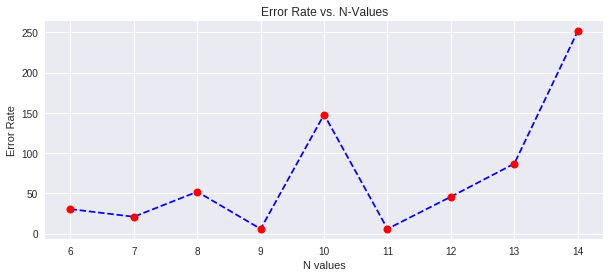

In [0]:
plt.figure(figsize=(10,4))
plt.plot(range(6,15), RMSE1, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=8)
plt.title('Error Rate vs. N-Values')
plt.xlabel('N values')
plt.ylabel('Error Rate')

##CNN

In [0]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
import time
import keras

In [0]:
def best_cnn_value(min_val,max_val):
  print('Build model...')
  RMSE=[]
  checkpointer = ModelCheckpoint(filepath="cnn_add_neural_project4.hdf5", verbose=0, save_best_only=True)
  for i in range(min_val,max_val+1):
  
    
    SEQUENCE_SIZE = i
    x_train,y_train1 = to_sequences(SEQUENCE_SIZE,df_train,df_y_train)
    x_test,y_test1 = to_sequences(SEQUENCE_SIZE,df_test,df_y_test)
    x_train1 = x_train.reshape(x_train.shape[0],1,SEQUENCE_SIZE,5)
    x_test1 = x_test.reshape(x_test.shape[0],1,SEQUENCE_SIZE,5)
    #print(x_train1,y_train1)
    model = Sequential()
    # my best cnn model
    cnn = Sequential()
    cnn.add(Conv2D(64, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=(1, i, 5)))

    # the above code is equivalent to 
    # model.add(Conv1D(64, kernel_size=3, strides=1, activation='relu', input_shape=(128, 1)))

    cnn.add(MaxPooling2D(pool_size=(1,1)))

    cnn.add(Conv2D(128, kernel_size=(1, 1), strides=(1, 1),
                 activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(1,1)))
    
    
    cnn.add(Flatten())
    cnn.add(Dense(1024, activation="relu"))
    #cnn.add(Dropout(0.5))
    cnn.add(Dense(1))
   
    cnn.compile(loss=keras.losses.mean_squared_error, optimizer='Adamax')


    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    cnn.fit(x_train1, y_train1,     
            batch_size=128,
            epochs=100,
            verbose=2,
            callbacks=[monitor],
            validation_data=(x_test1, y_test1))
   
    pred2 = cnn.predict(x_test1)
    score2 = np.sqrt(metrics.mean_squared_error(pred2,y_test1))
    print("(RMSE): {}".format(score2))
    print(i,"Completed")
    RMSE.append(score2)
    print(i,"Completed")
  print(RMSE)
  value = []
  j=min_val
  for i in range(len(RMSE)):
    value.append([j,RMSE[i]])
    j = j+1
  n = pd.DataFrame(data = np.array((value), dtype=object),columns = ['N','RMSE'])
  return n,RMSE
 

In [0]:
rmse_cnn,RMSE2 = best_cnn_value(6,14)
print(rmse_cnn)
#rmse_cnn[min('RMSE')]

Build model...
Train on 3067 samples, validate on 1311 samples
Epoch 1/100
 - 13s - loss: 166.4318 - val_loss: 5295.7325
Epoch 2/100
 - 0s - loss: 51.9416 - val_loss: 2884.1961
Epoch 3/100
 - 0s - loss: 29.1277 - val_loss: 1663.2697
Epoch 4/100
 - 0s - loss: 14.6368 - val_loss: 1200.9224
Epoch 5/100
 - 0s - loss: 6.0255 - val_loss: 601.4358
Epoch 6/100
 - 0s - loss: 2.3770 - val_loss: 408.7854
Epoch 7/100
 - 0s - loss: 1.4039 - val_loss: 339.9922
Epoch 8/100
 - 0s - loss: 1.0275 - val_loss: 310.5452
Epoch 9/100
 - 0s - loss: 0.9050 - val_loss: 275.0868
Epoch 10/100
 - 0s - loss: 0.8016 - val_loss: 264.7458
Epoch 11/100
 - 0s - loss: 0.7416 - val_loss: 241.7090
Epoch 12/100
 - 0s - loss: 0.6991 - val_loss: 188.4566
Epoch 13/100
 - 0s - loss: 0.6688 - val_loss: 188.2828
Epoch 14/100
 - 0s - loss: 0.6153 - val_loss: 195.1927
Epoch 15/100
 - 0s - loss: 0.5877 - val_loss: 159.2741
Epoch 16/100
 - 0s - loss: 0.5675 - val_loss: 155.8896
Epoch 17/100
 - 0s - loss: 0.5583 - val_loss: 162.8163
E

In [0]:
rmse_cnn,RMSE2 = best_cnn_value(4,12)
print(rmse_cnn)
#rmse_cnn[min('RMSE')]

Build model...
Train on 3069 samples, validate on 1313 samples
Epoch 1/100
 - 15s - loss: 199.4994 - val_loss: 776.4388
Epoch 2/100
 - 0s - loss: 63.0517 - val_loss: 3854.8295
Epoch 3/100
 - 0s - loss: 36.7632 - val_loss: 2873.1042
Epoch 4/100
 - 0s - loss: 21.9083 - val_loss: 1658.0018
Epoch 5/100
 - 0s - loss: 10.8830 - val_loss: 855.0496
Epoch 6/100
 - 0s - loss: 4.8909 - val_loss: 568.9636
Epoch 7/100
 - 0s - loss: 2.5174 - val_loss: 485.4292
Epoch 8/100
 - 0s - loss: 1.6948 - val_loss: 402.8795
Epoch 9/100
 - 0s - loss: 1.1965 - val_loss: 370.0890
Epoch 10/100
 - 0s - loss: 0.9602 - val_loss: 333.3070
Epoch 11/100
 - 0s - loss: 0.7863 - val_loss: 329.2109
Epoch 12/100
 - 0s - loss: 0.6966 - val_loss: 303.1022
Epoch 13/100
 - 0s - loss: 0.6073 - val_loss: 280.2141
Epoch 14/100
 - 0s - loss: 0.5457 - val_loss: 269.4698
Epoch 15/100
 - 0s - loss: 0.4982 - val_loss: 259.8772
Epoch 16/100
 - 0s - loss: 0.4589 - val_loss: 257.0653
Epoch 17/100
 - 0s - loss: 0.4444 - val_loss: 256.8175
E

Text(0, 0.5, 'Error Rate')

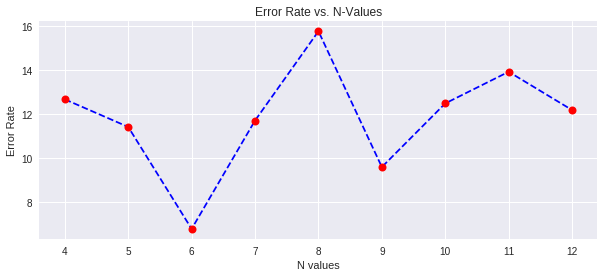

In [0]:
plt.figure(figsize=(10,4))
plt.plot(range(4,13), RMSE2, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=8)
plt.title('Error Rate vs. N-Values')
plt.xlabel('N values')
plt.ylabel('Error Rate')

# 2.LSTM for JPM


In [0]:
link1 = 'https://drive.google.com/open?id=1y0TGXk1CXA39E31gtdge_ALp6oordPFO'
fluff, file_id = link1.split('=')
print (file_id)
downloaded1 = drive.CreateFile({'id': file_id})
downloaded1.GetContentFile('JPM.csv') 
df_apple = pd.read_csv('JPM.csv')
df_apple.shape

1y0TGXk1CXA39E31gtdge_ALp6oordPFO


(9745, 7)

In [0]:
df_lstm_app = df_apple['Close'].copy()

In [0]:
df_apple.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,5.018518,5.129630,5.018518,5.037037,0.304709,62400
1,1980-03-18,5.037037,5.111111,5.037037,5.074074,0.306950,63900
2,1980-03-19,5.111111,5.166667,5.111111,5.148148,0.311431,40500
3,1980-03-20,5.148148,5.148148,5.092593,5.111111,0.309190,18900
4,1980-03-21,5.111111,5.222222,5.111111,5.222222,0.315912,97200


In [0]:
df_apple.describe()

,Open,High,Low,Close,Adj Close,Volume
count,9745.000000,9745.000000,9745.000000,9745.000000,9745.000000,9.745000e+03
mean,32.699838,33.085842,32.305111,32.700647,22.812098,1.175325e+07
std,23.666738,23.875379,23.455738,23.662388,24.482124,1.736990e+07
min,3.416667,3.625000,3.208333,3.375000,0.303589,1.110000e+04
25%,12.041667,12.166667,11.916667,12.041667,1.541489,1.017600e+06
50%,33.619999,34.119999,33.020000,33.599998,20.728096,6.377000e+06
75%,45.700001,46.180000,45.119999,45.689999,32.653263,1.424220e+07
max,119.129997,119.330002,118.080002,118.769997,117.805038,2.172942e+08


In [0]:
print(df_apple.shape)
df_apple.drop('Date',inplace=True,axis=1)
df_apple.drop('Adj Close',inplace=True,axis=1)
df_apple.shape

(9745, 7)


(9745, 5)

In [0]:
df_apple.drop_duplicates(inplace=True)
df_apple.dropna(how='any', inplace= True)
df_apple.shape

(9745, 5)

In [0]:
#normalise the features
encode_numeric_zscore(df_apple,'Open')
encode_numeric_zscore(df_apple,'Low')
encode_numeric_zscore(df_apple,'High')
encode_numeric_zscore(df_apple,'Volume')
encode_numeric_zscore(df_apple,'Close')

In [0]:
x_train_apple = df_apple[0:6688]
x_test_apple = df_apple[6688:9555]

y_train_apple = df_lstm_app[0:6688].tolist()
y_test_apple = df_lstm_app[6688:].tolist()


#df_y_train_goog = df_train_goog['Close'].tolist()
#df_y_test_goog = df_test_goog['Close'].tolist()



In [0]:
print(x_test_apple)
print(y_test_apple)

          Open      High       Low     Close    Volume
6689 -0.175548 -0.173511 -0.173692 -0.169867  1.609958
6690 -0.171165 -0.174035 -0.172532 -0.174313  1.703236
6691 -0.173714 -0.175114 -0.176953 -0.180872  1.572289
6692 -0.180461 -0.176255 -0.179399 -0.173567  1.484634
6693 -0.173776 -0.175762 -0.174194 -0.176364  0.808035
6694 -0.172719 -0.173788 -0.178333 -0.178416  1.767618
6695 -0.173372 -0.177149 -0.185670 -0.186778  2.859758
6696 -0.183850 -0.183193 -0.183977 -0.179815  1.794355
6697 -0.178409 -0.181805 -0.181656 -0.183949  1.401482
6698 -0.179621 -0.177149 -0.178239 -0.179349  2.263734
6699 -0.182482 -0.183039 -0.183851 -0.181773  1.852373
6700 -0.179528 -0.166666 -0.176953 -0.163401  2.334625
6701 -0.158386 -0.149492 -0.154407 -0.146056  3.170615
6702 -0.144924 -0.148351 -0.149045 -0.147454  1.506642
6703 -0.147256 -0.149707 -0.152871 -0.153578  1.855128
6704 -0.158137 -0.144774 -0.154031 -0.147299  2.600829
6705 -0.148219 -0.147241 -0.146192 -0.147175  1.354379
6706 -0.14

In [0]:
x_test_apple= list_convert(x_test_apple)
x_train_apple= list_convert(x_train_apple)

In [0]:
print(x_test_apple)
print(y_train_apple)
print(y_test_apple)
print(x_train_apple)

[[0.5793008708617355, 0.5643537437141461, 0.5881241977233586, 0.5831766754778109, -0.2378167742356668], [0.5983149403429463, 0.5974420986921263, 0.61626230246876, 0.6021942406401464, 0.2111553528299903], [0.5915543973286113, 0.5806885632658815, 0.6038987176780751, 0.5865576529603436, -0.03615180053547828], [0.5928219568904051, 0.5765000223437476, 0.5932403446684533, 0.5958549818174311, -0.2869650194176163], [0.6021177457885094, 0.6033060476062833, 0.6243627938565489, 0.6136047543808505, -0.153659687663131], [0.6076107292410503, 0.5974420986921263, 0.6124252881852963, 0.5962776779597813, -0.22858816500213452], [0.5915543973286113, 0.5802696379706085, 0.6056039294591382, 0.5967002473186453, -0.3285311820290343], [0.6088782888028443, 0.5953479329414411, 0.6158360528153594, 0.6005037518988798, 0.2059048901843375], [0.6004275677815317, 0.5806885632658815, 0.6004879530480117, 0.600081224801178, 0.03616295965316736], [0.5953572027741748, 0.5915783591987328, 0.610293656216864, 0.59754547055869

In [0]:
SEQUENCE_SIZE = 5
X_trainapp, Y_trainapp = to_sequences(SEQUENCE_SIZE, x_train_apple, y_train_apple)

print("Shape of x_train: {}".format(X_trainapp.shape))
print("Shape of y_train: {}".format(Y_trainapp.shape))

X_testapp, Y_testapp = to_sequences(SEQUENCE_SIZE, x_test_apple, y_test_apple)

print("Shape of x_test: {}".format(X_testapp.shape))
print("Shape of y_test: {}".format(Y_testapp.shape))

#SEQUENCE_SIZE = 7
#x_train,y_train = to_sequences(SEQUENCE_SIZE,x_test_apple,y_test_apple)
#_test,y_test = to_sequences(SEQUENCE_SIZE,x_train_apple,y_train_apple)


Shape of x_train: (6682, 5, 5)
Shape of y_train: (6682,)
Shape of x_test: (2861, 5, 5)
Shape of y_test: (2861,)


In [0]:
print(X_trainapp.shape,Y_trainapp.shape)
print(X_testapp.shape,Y_testapp.shape)

(6682, 5, 5) (6682,)
(2861, 5, 5) (2861,)


In [0]:
print(X_trainapp[0:5])
Y_trainapp[0:5]

[[[-1.16962972 -1.17092224 -1.16332275 -1.16909632 -0.67305249]
  [-1.16884723 -1.17169789 -1.16253322 -1.16753109 -0.67296614]
  [-1.16571735 -1.16937098 -1.15937519 -1.16440064 -0.6743133 ]
  [-1.16415241 -1.17014663 -1.16016468 -1.16596587 -0.67555683]
  [-1.16571735 -1.1670441  -1.15937519 -1.16127019 -0.67104903]]

 [[-1.16884723 -1.17169789 -1.16253322 -1.16753109 -0.67296614]
  [-1.16571735 -1.16937098 -1.15937519 -1.16440064 -0.6743133 ]
  [-1.16415241 -1.17014663 -1.16016468 -1.16596587 -0.67555683]
  [-1.16571735 -1.1670441  -1.15937519 -1.16127019 -0.67104903]
  [-1.16258747 -1.16859537 -1.16016468 -1.16674846 -0.67144627]]

 [[-1.16571735 -1.16937098 -1.15937519 -1.16440064 -0.6743133 ]
  [-1.16415241 -1.17014663 -1.16016468 -1.16596587 -0.67555683]
  [-1.16571735 -1.1670441  -1.15937519 -1.16127019 -0.67104903]
  [-1.16258747 -1.16859537 -1.16016468 -1.16674846 -0.67144627]
  [-1.1664998  -1.17169789 -1.16174374 -1.16753109 -0.67249981]]

 [[-1.16415241 -1.17014663 -1.1601

array([5.092593, 5.074074, 5.111111, 5.074074, 5.018518])

##best model 

In [0]:
model = Sequential()
model.add(LSTM(128, activation='relu',return_sequences=True,dropout=0.2, recurrent_dropout=0.2, input_shape=(5, 5)))
model.add(LSTM(64, activation='relu', dropout=0.2,recurrent_dropout=0.2))
#model.add(LSTM(128, activation='sigmoid', dropout=0.2, recurrent_dropout=0.2))

model.add(Dense(1))
model.compile(loss='mean_squared_error',
              optimizer='adam')

In [0]:
 
  from numpy import newaxis
  def predict_sequences_multiple(data, window_size, prediction_len):
  	#Predict sequence of 5 steps before shifting prediction run forward by 50 steps
		print('[Model] Predicting Sequences Multiple...')
		prediction_seqs = []
		for i in range(int(len(data)/prediction_len)):
			curr_frame = data[i*prediction_len]
			predicted = []
			for j in range(prediction_len):
				predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
				curr_frame = curr_frame[1:]
				curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
			prediction_seqs.append(predicted)
		return prediction_seqs

In [0]:
preds = predict_sequences_multiple(X_testapp, 5, 5)
print(preds)

[Model] Predicting Sequences Multiple...
[[16.36559, 33.8577, 36.682583, 37.875107, 38.537903], [16.1021, 33.846893, 36.7063, 37.890102, 38.561512], [16.728043, 34.169174, 36.898983, 37.94344, 38.568604], [17.709982, 34.33247, 36.85618, 37.972275, 38.574425], [18.00852, 34.516544, 36.963413, 38.019325, 38.582767], [16.895618, 34.37764, 37.01829, 38.025715, 38.583378], [17.063356, 34.328583, 36.840893, 37.918484, 38.56749], [16.827309, 34.072323, 36.805145, 37.93573, 38.55263], [15.554952, 33.576004, 36.709908, 37.914646, 38.550316], [17.292587, 34.316494, 36.837475, 37.939487, 38.554707], [17.471113, 34.416332, 36.983604, 37.981262, 38.58355], [16.117811, 34.11156, 36.93104, 37.992176, 38.573795], [17.951584, 34.320744, 36.848824, 37.969894, 38.579536], [18.561665, 34.704243, 37.097786, 38.040104, 38.5919], [19.5938, 35.039505, 37.08406, 38.048893, 38.58745], [20.282509, 35.350548, 37.296124, 38.10607, 38.61139], [20.159111, 35.561504, 37.338615, 38.12746, 38.609734], [21.000315, 35.55

In [0]:
preds = predict_sequences_multiple(X_testapp, 5, 5)
print(preds)

[Model] Predicting Sequences Multiple...
[[0.0143069085, 0.01188331, 0.008628935, 0.005398577, 0.0023799934], [0.013910062, 0.011421182, 0.008137001, 0.0048089256, 0.0023619554], [0.013528795, 0.010578721, 0.007366839, 0.004450583, 0.0024190964], [0.014035532, 0.0115451515, 0.008242122, 0.0047948384, 0.002272177], [0.014257816, 0.011568526, 0.0077283364, 0.0045182304, 0.0025401304], [0.0139828585, 0.011604407, 0.008308404, 0.004851505, 0.0024258988], [0.014629745, 0.011832187, 0.008261839, 0.0048484514, 0.002183404], [0.015802654, 0.012899639, 0.009183387, 0.0055723144, 0.0026486618], [0.015926944, 0.012836104, 0.00881478, 0.005151392, 0.002243176], [0.015852833, 0.013080513, 0.009569809, 0.005931569, 0.0028573892], [0.013703761, 0.01087745, 0.0075460933, 0.0045128474, 0.001951402], [0.01357877, 0.011379321, 0.008218998, 0.004883727, 0.0025654663], [0.01378006, 0.011560539, 0.008494863, 0.005051071, 0.002317216], [0.016010417, 0.013307971, 0.0093897, 0.005725533, 0.0024116545], [0.0171

In [0]:
lstm = np.sqrt(metrics.mean_squared_error(preds[0],Y_testapp[0:5]))
print("Predicted classes:",preds[0])
print("Expected classes:",Y_testapp[0:5])
print("After load score (RMSE): {}".format(lstm))
#chart_regression(pred1[0:1],y_test01)

Predicted classes: [0.0143069085, 0.01188331, 0.008628935, 0.005398577, 0.0023799934]
Expected classes: [46.810001 46.82     46.91     46.900002 46.84    ]
After load score (RMSE): 46.84750123422258


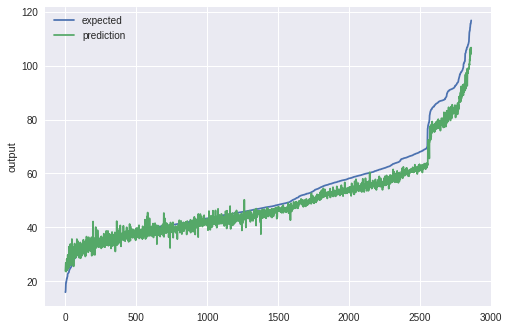

In [0]:
pred = [x for [x] in pred]
chart_regression(pred,Y_testapp)

#3.Bidirectional Layer

In [0]:
import numpy as np

def to_sequences(SEQUENCE_SIZE, data, col):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = col[i+SEQUENCE_SIZE]
        window = [x for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
     
        
    return np.array(x),np.array(y)

In [0]:
def list_convert(x):
  x1 = []
  for i in range(0,x.shape[0]):
    x1.append(x.iloc[i,:].tolist())
  return x1

In [0]:
df_train = df[0:3074]
df_test = df[3074:4392]

df_y_train = df_train['Close'].tolist()
df_y_test = df_test['Close'].tolist()


In [0]:
df_train = list_convert(df_train)
df_test = list_convert(df_test)

In [0]:
SEQUENCE_SIZE = 7
x_train,y_train = to_sequences(SEQUENCE_SIZE,df_train,df_y_train)
x_test,y_test = to_sequences(SEQUENCE_SIZE,df_test,df_y_test)


In [0]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(3066, 7, 5) (3066,)
(1310, 7, 5) (1310,)


In [0]:
from keras.layers import Bidirectional, LSTM 
checkpointer = ModelCheckpoint(filepath="bilstm_neural_project4.hdf5", verbose=0, save_best_only=True) # save best model
optimizer = ['Adam', 'Adamax']
for each in optimizer:
  SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  Adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

  for i in range(1):
  
    print(i)
    model = Sequential()
   
    model.add(Bidirectional(LSTM(64, activation='relu', dropout=0.2,return_sequences=True, recurrent_dropout=0.2, input_shape=(7, 5))))
   
    model.add(Bidirectional(LSTM(128, activation='relu', dropout=0.2, recurrent_dropout=0.2)))
  
    #model.add(Bidirectional(LSTM(32, activation='relu', dropout=0.2,recurrent_dropout=0.2)))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
              optimizer=each)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=100)
    pred = model.predict(x_test)
    score2 = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("(RMSE): {}".format(score2))
    print(each,"ends")
model.save(os.path.join(save_path,"bilstm_neural_project4.hdf5"))

0
Train...
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 28s - loss: 179.6659 - val_loss: 62326.0670
Epoch 2/100
 - 8s - loss: 17.4555 - val_loss: 8736.6576
Epoch 3/100
 - 8s - loss: 9.6186 - val_loss: 10016.5666
Epoch 4/100
 - 8s - loss: 7.2976 - val_loss: 4262.2179
Epoch 5/100
 - 8s - loss: 6.0468 - val_loss: 806.5337
Epoch 6/100
 - 8s - loss: 5.0715 - val_loss: 2077.7979
Epoch 7/100
 - 8s - loss: 4.6397 - val_loss: 4208.2921
Epoch 8/100
 - 8s - loss: 4.1152 - val_loss: 2395.4506
Epoch 9/100
 - 8s - loss: 4.0886 - val_loss: 1962.0858
Epoch 10/100
 - 8s - loss: 3.7474 - val_loss: 719.3429
Epoch 11/100
 - 8s - loss: 3.4302 - val_loss: 1440.2968
Epoch 12/100
 - 8s - loss: 3.2616 - val_loss: 1414.6637
Epoch 13/100
 - 8s - loss: 3.1243 - val_loss: 2268.3900
Epoch 14/100
 - 8s - loss: 2.8767 - val_loss: 1607.5067
Epoch 15/100
 - 8s - loss: 2.7663 - val_loss: 300.5559
Epoch 16/100
 - 8s - loss: 2.9816 - val_loss: 625.3395
Epoch 17/100
 - 8s - loss: 2.6375 - val_loss: 747.47

In [0]:
 for i in range(2):
  model = Sequential()
   
  model.add(Bidirectional(LSTM(32, activation='relu', dropout=0.2, recurrent_dropout=0.2, input_shape=(7, 5))))
  
    #model.add(LSTM(64, activation='relu', dropout=0.2, recurrent_dropout=0.2))
  
    #model.add(LSTM(128, activation='sigmoid', dropout=0.2, recurrent_dropout=0.2))

  model.add(Dense(1))
  model.compile(loss='mean_squared_error',
              optimizer='adam')

  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
  print('Train...')
  model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
  pred = model.predict(x_test)
  score2 = np.sqrt(metrics.mean_squared_error(pred,y_test))
  print("(RMSE): {}".format(score2))

Train...
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 24s - loss: 305.2228 - val_loss: 32858.9559
Epoch 2/100
 - 4s - loss: 109.3942 - val_loss: 16931.2315
Epoch 3/100
 - 5s - loss: 35.0777 - val_loss: 2846.4588
Epoch 4/100
 - 4s - loss: 19.8872 - val_loss: 430.0256
Epoch 5/100
 - 4s - loss: 13.2414 - val_loss: 158.0081
Epoch 6/100
 - 4s - loss: 10.7656 - val_loss: 55.6513
Epoch 7/100
 - 4s - loss: 8.9080 - val_loss: 50.0954
Epoch 8/100
 - 4s - loss: 8.0493 - val_loss: 43.9357
Epoch 9/100
 - 4s - loss: 7.3771 - val_loss: 60.1860
Epoch 10/100
 - 4s - loss: 6.4033 - val_loss: 36.6801
Epoch 11/100
 - 4s - loss: 5.5192 - val_loss: 48.2321
Epoch 12/100
 - 4s - loss: 5.3548 - val_loss: 23.2242
Epoch 13/100
 - 4s - loss: 5.0087 - val_loss: 27.0411
Epoch 14/100
 - 4s - loss: 4.9176 - val_loss: 21.3874
Epoch 15/100
 - 4s - loss: 4.2941 - val_loss: 22.1179
Epoch 16/100
 - 4s - loss: 4.1419 - val_loss: 18.0184
Epoch 17/100
 - 4s - loss: 3.8206 - val_loss: 17.9284
Epoch 18/100
 -

In [0]:
#best model lstm
checkpointer = ModelCheckpoint(filepath="lstm_neural_project4_11.hdf5", verbose=0, save_best_only=True) # save best model
optimizer = ['Adam']
for each in optimizer:
  Adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)

  for i in range(2):
  
    print(i)
    model = Sequential()
   
    model.add(Bidirectional(LSTM(128, activation='relu',return_sequences=True,dropout=0.1, recurrent_dropout=0.1, input_shape=(7, 5))))

    model.add(Bidirectional(LSTM(64, activation='relu', dropout=0.1,recurrent_dropout=0.1)))
  
    #model.add(LSTM(128, activation='sigmoid', dropout=0.2, recurrent_dropout=0.2))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
              optimizer=each)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    pred = model.predict(x_test)
    score2 = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("(RMSE): {}".format(score2))
    print(each,"ends")
    model.load_weights('lstm_neural_project4_11.hdf5') # load weights from best model
model.save(os.path.join(save_path,"lstm_neural_project4_11.hdf5"))

0
Train...
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 25s - loss: 24.1269 - val_loss: 207.1350
Epoch 2/100
 - 10s - loss: 5.7204 - val_loss: 300.5889
Epoch 3/100
 - 10s - loss: 2.9599 - val_loss: 137.9162
Epoch 4/100
 - 10s - loss: 2.8680 - val_loss: 138.9127
Epoch 5/100
 - 10s - loss: 3.4357 - val_loss: 127.5868
Epoch 6/100
 - 10s - loss: 2.1573 - val_loss: 168.4402
Epoch 7/100
 - 10s - loss: 1.8447 - val_loss: 168.3521
Epoch 8/100
 - 10s - loss: 1.5401 - val_loss: 231.8048
Epoch 00008: early stopping
(RMSE): 15.225138422233607
Adam ends
1
Train...
Train on 3066 samples, validate on 1310 samples
Epoch 1/100
 - 23s - loss: 24.8171 - val_loss: 238.5231
Epoch 2/100
 - 10s - loss: 4.8081 - val_loss: 193.2667
Epoch 3/100
 - 10s - loss: 3.0124 - val_loss: 129.4112
Epoch 4/100
 - 10s - loss: 3.0657 - val_loss: 206.9327
Epoch 5/100
 - 10s - loss: 2.0989 - val_loss: 60.8460
Epoch 6/100
 - 10s - loss: 1.9428 - val_loss: 136.9105
Epoch 7/100
 - 10s - loss: 1.6368 - val_loss: 

# 4.Good model for stock price prediction with Google dataset

In [0]:
link2 = 'https://drive.google.com/open?id=1bno9120nyJvk2xXibbG8v0RxrBPYAXK8'

fluff, file_id = link2.split('=')
print (file_id)
downloaded2 = drive.CreateFile({'id': file_id})
downloaded2.GetContentFile('GOOG.csv') 


1bno9120nyJvk2xXibbG8v0RxrBPYAXK8


In [0]:
df_goog = pd.read_csv('GOOG.csv')
df_goog.shape

(3578, 7)

In [0]:
df_lstm_goog = df_goog['Close']. copy()

In [0]:
df_goog.dropna(how='any', inplace= True)
df_goog.drop_duplicates(inplace=True)

In [0]:
df_goog.dtypes

Date         object 
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       int64  
dtype: object

In [0]:
print(df_goog.shape)
df_goog.drop('Date',inplace=True,axis=1)
df_goog.drop('Adj Close',inplace=True,axis=1)
df_goog.shape

(3578, 7)


(3578, 5)

In [0]:
#normalise the features
encode_numeric_zscore(df_goog,'Open')
encode_numeric_zscore(df_goog,'Low')
encode_numeric_zscore(df_goog,'High')
encode_numeric_zscore(df_goog,'Volume')


In [0]:
x,y= to_xy(df_goog, 'Close')
print(x.shape,y.shape)

(3578, 4) (3578,)


In [0]:
x_train_goog, x_test_goog, y_train_goog, y_test_goog = train_test_split(x, y, test_size=0.30, random_state=45)
print(x_train_goog.shape,y_train_goog.shape)
print(x_test_goog.shape,y_test_goog.shape)

(2504, 4) (2504,)
(1074, 4) (1074,)


## FCNN

In [0]:

checkpointer = ModelCheckpoint(filepath="goog_project4_1.hdf5", verbose=0, save_best_only=True) # save best model
optimizer = [ 'Adagrad', 'Adam', 'Adamax']
for each in optimizer:
  Adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

  for i in range(2):
  
    print(i)
    model = Sequential()
    model.add(Dense(25, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(25,activation='relu'))
    model.add(Dense(25,activation='relu'))
    model.add(Dense(25,activation='relu'))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer=each)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    model.fit(x_train_goog, y_train_goog,validation_data=(x_test_goog,y_test_goog),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    pred2 = model.predict(x_test_goog)
    score = np.sqrt(metrics.mean_squared_error(pred2,y_test_goog))
    print("RMSE: {}".format(score))
    print(each,"ends")
    #loop ends
  
print('Training finished...Loading the best model')  
print()
model.load_weights('goog_project4_1.hdf5') # load weights from best model
model.save(os.path.join(save_path,"goog_project4_1.hdf5"))

0
Train on 2504 samples, validate on 1074 samples
Epoch 1/100
 - 13s - loss: 181006.6708 - val_loss: 40459.0038
Epoch 2/100
 - 0s - loss: 13701.2468 - val_loss: 7703.3405
Epoch 3/100
 - 0s - loss: 5506.9899 - val_loss: 4634.9927
Epoch 4/100
 - 0s - loss: 3495.0435 - val_loss: 3288.9248
Epoch 5/100
 - 0s - loss: 2507.7833 - val_loss: 2465.8042
Epoch 6/100
 - 0s - loss: 1942.1097 - val_loss: 1965.4357
Epoch 7/100
 - 0s - loss: 1569.4946 - val_loss: 1618.4488
Epoch 8/100
 - 0s - loss: 1298.2015 - val_loss: 1372.4771
Epoch 9/100
 - 0s - loss: 1088.9098 - val_loss: 1124.3639
Epoch 10/100
 - 0s - loss: 920.7945 - val_loss: 959.0734
Epoch 11/100
 - 0s - loss: 787.9504 - val_loss: 827.2220
Epoch 12/100
 - 0s - loss: 677.4879 - val_loss: 710.0013
Epoch 13/100
 - 0s - loss: 584.4962 - val_loss: 612.2186
Epoch 14/100
 - 0s - loss: 506.5570 - val_loss: 532.4399
Epoch 15/100
 - 0s - loss: 441.3700 - val_loss: 463.3883
Epoch 16/100
 - 0s - loss: 384.4926 - val_loss: 404.1213
Epoch 17/100
 - 0s - los

In [0]:
#loading the best saved model
from keras.models import load_model
model = load_model(os.path.join(save_path,"goog_project4_1.hdf5"))
pred2 = model.predict(x_test_goog)
print (pred2.shape)
print(y_test_goog.shape)
# Measure RMSE error.  RMSE is common for regression.
fcnn = np.sqrt(metrics.mean_squared_error(pred2,y_test_goog))
print("After load score (RMSE): {}".format(fcnn))

(1074, 1)
(1074,)
After load score (RMSE): 4.234368324279785


In [0]:
from keras.layers.core import Dropout
checkpointer = ModelCheckpoint(filepath="neural_project4_12.hdf5", verbose=0, save_best_only=True) # save best model
Adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)

for i in range(6):
  print(i)
  model = Sequential()
  model.add(Dense(32, input_dim=x.shape[1], activation='relu'))
  model.add(Dense(16,activation='relu'))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='Adam')

  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')

  model.fit(x_train_goog, y_train_goog,validation_data=(x_test_goog,y_test_goog),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
  pred2 = model.predict(x_test_goog)
  score = np.sqrt(metrics.mean_squared_error(pred2,y_test_goog))
  print("RMSE: {}".format(score))
  #loop ends
  
print('Training finished')  
print()
model.load_weights('neural_project4_12.hdf5') # load weights from best model
model.save(os.path.join(save_path,"neural_project4_12.hdf5"))
#model.save(os.path.join(save_path,"neural_project3mc.hdf5"))

0
Train on 2504 samples, validate on 1074 samples
Epoch 1/100
 - 11s - loss: 264771.7171 - val_loss: 280773.3333
Epoch 2/100
 - 0s - loss: 260250.9481 - val_loss: 272098.5698
Epoch 3/100
 - 0s - loss: 245541.3983 - val_loss: 247451.5307
Epoch 4/100
 - 0s - loss: 212655.7259 - val_loss: 201242.4024
Epoch 5/100
 - 0s - loss: 162400.5448 - val_loss: 141584.1032
Epoch 6/100
 - 0s - loss: 106053.0915 - val_loss: 83040.2020
Epoch 7/100
 - 0s - loss: 57473.1446 - val_loss: 38954.4252
Epoch 8/100
 - 0s - loss: 25687.2304 - val_loss: 16027.2465
Epoch 9/100
 - 0s - loss: 11236.7468 - val_loss: 8644.4643
Epoch 10/100
 - 0s - loss: 7173.1868 - val_loss: 6877.2951
Epoch 11/100
 - 0s - loss: 5777.7430 - val_loss: 5862.4981
Epoch 12/100
 - 0s - loss: 4861.3140 - val_loss: 5059.4540
Epoch 13/100
 - 0s - loss: 4221.7745 - val_loss: 4487.9863
Epoch 14/100
 - 0s - loss: 3786.4455 - val_loss: 4077.2599
Epoch 15/100
 - 0s - loss: 3476.3576 - val_loss: 3768.1013
Epoch 16/100
 - 0s - loss: 3240.1571 - val_lo

In [0]:
#loading the best saved model
from keras.models import load_model
model = load_model(os.path.join(save_path,"neural_project4_12.hdf5"))
pred2 = model.predict(x_test_goog)
print (pred2.shape)
print(y_test_goog.shape)
# Measure RMSE error.  RMSE is common for regression.
fcnngoog = np.sqrt(metrics.mean_squared_error(pred2,y_test_goog))
print("After load score (RMSE): {}".format(fcnngoog))

(1074, 1)
(1074,)
After load score (RMSE): 4.573984146118164


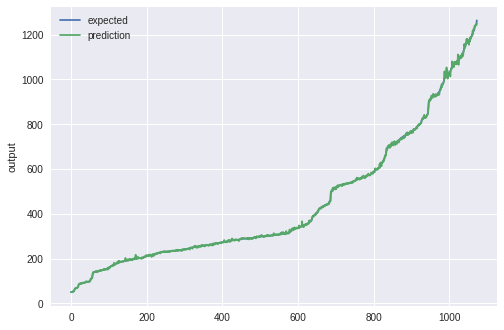

In [0]:
pred = [x for [x] in pred2]
chart_regression(pred,y_test_goog)

## LSTM

In [0]:
encode_numeric_zscore(df_goog,'Close')

In [0]:
df_x_train_goog = df_goog[0:2504]
df_x_test_goog = df_goog[2504:]

#df_y_train_goog = df_train_goog['Close'].tolist()
#df_y_test_goog = df_test_goog['Close'].tolist()

df_y_train_goog = df_lstm_goog[0:2504].tolist()
df_y_test_goog = df_lstm_goog[2504:].tolist()

In [0]:
df_x_train_goog.shape

(2504, 5)

In [0]:
df_x_test_goog = list_convert(df_x_test_goog)

In [0]:
df_x_train_goog = list_convert(df_x_train_goog)

In [0]:
SEQUENCE_SIZE = 10
x_train_goog1,y_train_goog1 = to_sequences(SEQUENCE_SIZE,df_x_train_goog,df_y_train_goog)
x_test_goog1,y_test_goog1 = to_sequences(SEQUENCE_SIZE,df_x_test_goog,df_y_test_goog)


In [0]:
print(x_train_goog1.shape,y_train_goog1.shape)
print(x_test_goog1.shape,y_test_goog1.shape)

(2493, 10, 5) (2493,)
(1063, 10, 5) (1063,)


In [0]:
y_train_goog1[0:5]

array([50.427021, 49.681866, 50.461796, 50.819469, 50.824436])

In [0]:
y_test_goog1[0:5]

array([571.507568, 570.343933, 578.976501, 583.650757, 581.293762])

In [0]:

checkpointer = ModelCheckpoint(filepath="lstm_goog_neural_project4.hdf5", verbose=0, save_best_only=True) # save best model
optimizer = ['Adagrad', 'Adam', 'Adamax']
for each in optimizer:
 # SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  Adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

  for i in range(2):
  
    print(i)
    model = Sequential()
   
    model.add(LSTM(128, activation='relu', dropout=0.2,return_sequences=True, recurrent_dropout=0.2, input_shape=(10, 5)))

    model.add(LSTM(58, activation='relu', dropout=0.2,return_sequences=True, recurrent_dropout=0.2))
  
    model.add(LSTM(28, activation='relu', dropout=0.2, recurrent_dropout=0.2))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
              optimizer=each)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train_goog1, y_train_goog1,validation_data=(x_test_goog1,y_test_goog1),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    pred = model.predict(x_test_goog1)
    score = np.sqrt(metrics.mean_squared_error(pred,y_test_goog1))
    print("(RMSE): {}".format(score))
    print(each,"ends")
    #model.load_weights('neural_project4.hdf5') # load weights from best model
    model.save(os.path.join(save_path,"lstm_goog_neural_project4.hdf5"))

0
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train...
Instructions for updating:
Use tf.cast instead.
Train on 2493 samples, validate on 1063 samples
Epoch 1/100
 - 11s - loss: 124978.2847 - val_loss: 106774.3889
Epoch 2/100
 - 7s - loss: 9945.9835 - val_loss: 77119.7571
Epoch 3/100
 - 7s - loss: 7596.6613 - val_loss: 32843.8422
Epoch 4/100
 - 7s - loss: 6466.7531 - val_loss: 94872.3369
Epoch 5/100
 - 7s - loss: 5984.0648 - val_loss: 130708.1860
Epoch 6/100
 - 7s - loss: 5330.8165 - val_loss: 90075.3014
Epoch 7/100
 - 7s - loss: 5017.9705 - val_loss: 61576.9809
Epoch 8/100
 - 7s - loss: 4655.2752 - val_loss: 20411.2459
Epoch 9/100
 - 7s - loss: 4220.2643 - val_loss: 84369.8127
Epoch 10/100
 - 7s - loss: 4046.4568 - val_loss: 52372.3256
Epoch 11/100
 - 7s - loss: 3676.9027 - val_loss: 71309.1640
Epoch 12/100
 - 7s - loss: 3548.8418 - val_loss: 78548.2490
Epoch 13/100
 - 7s - loss: 3454.4843 - val_loss: 86773.6350
Ep

In [0]:

checkpointer = ModelCheckpoint(filepath="lstm_goog_neural_project4_1.hdf5", verbose=0, save_best_only=True) # save best model
optimizer = ['Adagrad', 'Adam', 'Adamax']
for each in optimizer:
 # SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  Adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

  for i in range(2):
  
    print(i)
    model = Sequential()
   
    model.add(LSTM(256, activation='relu', dropout=0.2,return_sequences=True, recurrent_dropout=0.2, input_shape=(10, 5)))

    model.add(LSTM(128, activation='relu', dropout=0.2,return_sequences=True, recurrent_dropout=0.2))
  
    model.add(LSTM(64, activation='relu', dropout=0.2, recurrent_dropout=0.2))
    
    

    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
              optimizer=each)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train_goog1, y_train_goog1,validation_data=(x_test_goog1,y_test_goog1),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    pred = model.predict(x_test_goog1)
    score = np.sqrt(metrics.mean_squared_error(pred,y_test_goog1))
    print("(RMSE): {}".format(score))
    print(each,"ends")
    #model.load_weights('neural_project4.hdf5') # load weights from best model
    model.save(os.path.join(save_path,"lstm_goog_neural_project4_1.hdf5"))

0
Train...
Train on 2493 samples, validate on 1063 samples
Epoch 1/100
 - 14s - loss: 81269549.9159 - val_loss: 8449270.9493
Epoch 2/100
 - 7s - loss: 12606.1935 - val_loss: 4184070.0683
Epoch 3/100
 - 7s - loss: 8618.7671 - val_loss: 2893266.5977
Epoch 4/100
 - 7s - loss: 7002.4519 - val_loss: 1931029.8176
Epoch 5/100
 - 7s - loss: 5813.6218 - val_loss: 1617745.8124
Epoch 6/100
 - 7s - loss: 5353.8062 - val_loss: 790226.3083
Epoch 7/100
 - 7s - loss: 5239.9850 - val_loss: 939883.0643
Epoch 8/100
 - 7s - loss: 4744.5936 - val_loss: 891765.8858
Epoch 9/100
 - 7s - loss: 4280.2919 - val_loss: 1069243.2297
Epoch 10/100
 - 7s - loss: 3971.5969 - val_loss: 766120.6944
Epoch 11/100
 - 7s - loss: 3826.2484 - val_loss: 517985.2699
Epoch 12/100
 - 7s - loss: 3763.8226 - val_loss: 613369.7121
Epoch 13/100
 - 7s - loss: 3371.7583 - val_loss: 682106.8595
Epoch 14/100
 - 7s - loss: 3377.1481 - val_loss: 407996.8624
Epoch 15/100
 - 7s - loss: 3114.3846 - val_loss: 416537.6372
Epoch 16/100
 - 7s - lo

In [0]:
#best model lstm
checkpointer = ModelCheckpoint(filepath="lstm_neural_project4goog.hdf5", verbose=0, save_best_only=True) # save best model
optimizer = ['Adam']
for each in optimizer:
  Adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)

  for i in range(3):
  
    print(i)
    model = Sequential()
   
    model.add(LSTM(128, activation='relu',return_sequences=True,dropout=0.2, recurrent_dropout=0.2, input_shape=(10, 5)))

    model.add(LSTM(64, activation='relu', dropout=0.2,recurrent_dropout=0.2))
  
    #model.add(LSTM(128, activation='sigmoid', dropout=0.2, recurrent_dropout=0.2))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
              optimizer=each)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train_goog1, y_train_goog1,validation_data=(x_test_goog1,y_test_goog1),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    pred = model.predict(x_test_goog1)
    score = np.sqrt(metrics.mean_squared_error(pred,y_test_goog1))
    print("(RMSE): {}".format(score))
    print(each,"ends")
    model.load_weights('lstm_neural_project4goog.hdf5') # load weights from best model
model.save(os.path.join(save_path,"lstm_neural_project4goog.hdf5"))

0
Train...
Train on 2493 samples, validate on 1063 samples
Epoch 1/100
 - 18s - loss: 67974.5644 - val_loss: 2170785.8043
Epoch 2/100
 - 5s - loss: 10343.1724 - val_loss: 68138.7888
Epoch 3/100
 - 5s - loss: 4542.9178 - val_loss: 6248.4059
Epoch 4/100
 - 5s - loss: 3044.0463 - val_loss: 6612.1285
Epoch 5/100
 - 5s - loss: 2290.4258 - val_loss: 5242.0388
Epoch 6/100
 - 5s - loss: 2199.3208 - val_loss: 5669.6980
Epoch 7/100
 - 5s - loss: 1856.3741 - val_loss: 5034.8272
Epoch 8/100
 - 5s - loss: 1740.2958 - val_loss: 5877.4253
Epoch 9/100
 - 5s - loss: 1696.6075 - val_loss: 4295.9472
Epoch 10/100
 - 5s - loss: 1576.3854 - val_loss: 4311.1296
Epoch 11/100
 - 5s - loss: 1469.2526 - val_loss: 2728.0980
Epoch 12/100
 - 5s - loss: 1391.3818 - val_loss: 3027.9133
Epoch 13/100
 - 5s - loss: 1384.3854 - val_loss: 3133.1493
Epoch 14/100
 - 5s - loss: 1249.9834 - val_loss: 4384.7718
Epoch 00014: early stopping
(RMSE): 66.21760973188786
Adam ends
1
Train...
Train on 2493 samples, validate on 1063 sa

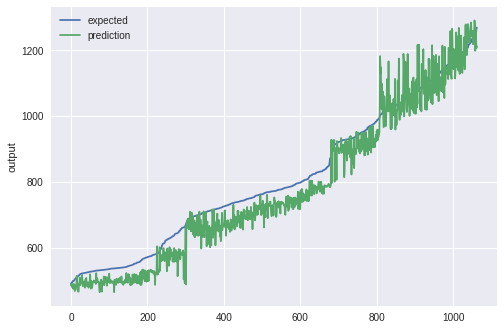

In [0]:
pred_goog = [x for [x] in pred]
chart_regression(pred_goog,y_test_goog1)

## CNN

In [0]:
SEQUENCE_SIZE = 10
x_train_goog_cnn ,y_train_goog_cnn = CNN_to_sequences(SEQUENCE_SIZE,df_x_train_goog,df_y_train_goog)
x_test_goog_cnn,y_test_goog_cnn = CNN_to_sequences(SEQUENCE_SIZE,df_x_test_goog,df_y_test_goog)
print(x_train_goog_cnn.shape,y_train_goog_cnn.shape)
print(x_test_goog_cnn.shape,y_test_goog_cnn.shape)

(2493, 10, 1, 5) (2493,)
(1063, 10, 1, 5) (1063,)


In [0]:

x_train_goog_cnn = x_train_goog_cnn.reshape(x_train_goog_cnn.shape[0],1,SEQUENCE_SIZE,5)
x_test_goog_cnn = x_test_goog_cnn.reshape(x_test_goog_cnn.shape[0],1,SEQUENCE_SIZE,5)
print(x_train_goog_cnn.shape,y_train_goog_cnn.shape)
print(x_test_goog_cnn.shape,y_test_goog_cnn.shape)

(2493, 1, 10, 5) (2493,)
(1063, 1, 10, 5) (1063,)


In [0]:
# define a CNN

cnn_goog = Sequential()
cnn_goog.add(Conv2D(64, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=(1, 10, 5)))

# the above code is equivalent to 
# model.add(Conv1D(64, kernel_size=3, strides=1, activation='relu', input_shape=(128, 1)))

cnn_goog.add(MaxPooling2D(pool_size=(1,1)))

cnn_goog.add(Conv2D(128, kernel_size=(1, 1), strides=(1, 1),
                 activation='relu'))
cnn_goog.add(MaxPooling2D(pool_size=(1,1)))
    
    
cnn_goog.add(Flatten())
cnn_goog.add(Dense(1024, activation="relu"))
#cnn.add(Dropout(0.5))
cnn_goog.add(Dense(1))

# define optimizer and objective, compile cnn

cnn_goog.compile(loss="mean_squared_error", optimizer="adam")
cnn_goog.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_86 (Conv2D)           (None, 1, 8, 64)          1024      
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 1, 8, 64)          0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 1, 8, 128)         8320      
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 1, 8, 128)         0         
_________________________________________________________________
flatten_43 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_121 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
dense_122 (Dense)            (None, 1)                 1025      
Total para

In [0]:
optimizer = ['Adamax']
for each in optimizer:
  SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

  start_time = time.time()
  checkpointer = ModelCheckpoint(filepath="cnn_project4_g.hdf5", verbose=0, save_best_only=True) # save best model
  for i in range(5):
  
    print(i)
  
    cnn_goog.compile(loss=keras.losses.mean_squared_error, optimizer=each)


    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    cnn_goog.fit(x_train_goog_cnn, y_train_goog_cnn,     
            batch_size=128,
            epochs=100,
            verbose=2,
            callbacks=[monitor,checkpointer],
            validation_data=(x_test_goog_cnn, y_test_goog_cnn))
   
    pred_cnn = cnn_goog.predict(x_test_goog_cnn)
    score = np.sqrt(metrics.mean_squared_error(pred_cnn,y_test_goog_cnn))
    print("(RMSE): {}".format(score))
    print(each,"ends")
  print('Training finished...Loading the best model')  
  print()
  elapsed_time = time.time() - start_time
  print("Elapsed time: {}".format(hms_string(elapsed_time)))
  #model.load_weights('cnn_project4_g.hdf5')       
#cnn.save(os.path.join(save_path,"cnn_project4_g.hdf5"))         

0
Train on 2493 samples, validate on 1063 samples
Epoch 1/100
 - 23s - loss: 628.5411 - val_loss: 619.1514
Epoch 2/100
 - 0s - loss: 119.5594 - val_loss: 696.4655
Epoch 3/100
 - 0s - loss: 79.4405 - val_loss: 1333.1180
Epoch 4/100
 - 0s - loss: 74.8090 - val_loss: 980.7292
Epoch 5/100
 - 0s - loss: 71.2185 - val_loss: 1014.6050
Epoch 6/100
 - 0s - loss: 70.0402 - val_loss: 905.1206
Epoch 00006: early stopping
(RMSE): 30.08522284954436
Adamax ends
1
Train on 2493 samples, validate on 1063 samples
Epoch 1/100
 - 23s - loss: 571.8171 - val_loss: 582.2115
Epoch 2/100
 - 0s - loss: 115.4798 - val_loss: 557.7173
Epoch 3/100
 - 0s - loss: 78.2734 - val_loss: 723.8756
Epoch 4/100
 - 0s - loss: 72.5852 - val_loss: 720.9720
Epoch 5/100
 - 0s - loss: 71.0162 - val_loss: 623.7201
Epoch 6/100
 - 0s - loss: 70.0676 - val_loss: 603.9750
Epoch 7/100
 - 0s - loss: 70.0676 - val_loss: 660.9638
Epoch 00007: early stopping
(RMSE): 25.709216684813764
Adamax ends
2
Train on 2493 samples, validate on 1063 sa

In [0]:
optimizer = ['Adamax']
for each in optimizer:
  SGD = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
  Adamax = optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
  Adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

  start_time = time.time()
  checkpointer = ModelCheckpoint(filepath="cnn_project4_g.hdf5", verbose=0, save_best_only=True) # save best model
  for i in range(5):
  
    print(i)
  
    cnn_goog.compile(loss=keras.losses.mean_squared_error, optimizer=each)


    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    cnn_goog.fit(x_train_goog_cnn, y_train_goog_cnn,     
            batch_size=128,
            epochs=100,
            verbose=2,
            callbacks=[monitor,checkpointer],
            validation_data=(x_test_goog_cnn, y_test_goog_cnn))
   
    pred_cnn = cnn_goog.predict(x_test_goog_cnn)
    score = np.sqrt(metrics.mean_squared_error(pred_cnn,y_test_goog_cnn))
    print("(RMSE): {}".format(score))
    print(each,"ends")
  print('Training finished...Loading the best model')  
  print()
  elapsed_time = time.time() - start_time
  print("Elapsed time: {}".format(hms_string(elapsed_time)))
  #model.load_weights('cnn_project4_g.hdf5')       
#cnn.save(os.path.join(save_path,"cnn_project4_g.hdf5"))         

0
Train on 2493 samples, validate on 1063 samples
Epoch 1/100
 - 22s - loss: 481.4693 - val_loss: 2644.2082
Epoch 2/100
 - 0s - loss: 106.5271 - val_loss: 2710.3514
Epoch 3/100
 - 0s - loss: 82.3982 - val_loss: 3813.9806
Epoch 4/100
 - 0s - loss: 76.4957 - val_loss: 4096.3242
Epoch 5/100
 - 0s - loss: 73.3640 - val_loss: 4024.9832
Epoch 6/100
 - 0s - loss: 72.9855 - val_loss: 3990.4016
Epoch 00006: early stopping
(RMSE): 63.16962524934937
Adamax ends
1
Train on 2493 samples, validate on 1063 samples
Epoch 1/100
 - 22s - loss: 414.2826 - val_loss: 875.2852
Epoch 2/100
 - 0s - loss: 99.2536 - val_loss: 1263.5468
Epoch 3/100
 - 0s - loss: 76.5282 - val_loss: 1696.8962
Epoch 4/100
 - 0s - loss: 72.7236 - val_loss: 2050.1382
Epoch 5/100
 - 0s - loss: 71.1169 - val_loss: 2173.0167
Epoch 6/100
 - 0s - loss: 70.5566 - val_loss: 2294.8347
Epoch 00006: early stopping
(RMSE): 47.90443283637337
Adamax ends
2
Train on 2493 samples, validate on 1063 samples
Epoch 1/100
 - 22s - loss: 739.5651 - val_

In [0]:
#loading the best saved model
from keras.models import load_model
model1 = load_model(os.path.join(save_path,"cnn_project4_g.hdf5"))
pred1 = model1.predict(x_test_goog_cnn)
cnns = np.sqrt(metrics.mean_squared_error(pred1,y_test_goog_cnn))
print("After load score (RMSE): {}".format(cnns))
cnnr2=metrics.r2_score(pred1,y_test_goog_cnn)
print ("R2 score:",cnnr2)
print (pred1.shape)
# Measure RMSE error.  RMSE is common for regression.

print("Predicted classes:",pred1[0:1])
print("Expected classes:",x_test_goog_cnn[0:1])

#chart_regression(pred1[0:1],y_test01)

After load score (RMSE): 87.54518229917848
R2 score: 0.8930935084724093
(1063, 1)
Predicted classes: [[567.01953]]
Expected classes: [[[[ 0.49858     0.49204835  0.48019081  0.4677266  -0.66078916]
   [ 0.46333844  0.46567371  0.45529715  0.44862409 -0.67870172]
   [ 0.45863965  0.4635817   0.45964918  0.47308076 -0.74281875]
   [ 0.46212918  0.45202354  0.45446148  0.44516962 -0.72776445]
   [ 0.43355604  0.44763345  0.44537451  0.4496741  -0.75410645]
   [ 0.45504643  0.44485526  0.44920412  0.43926279 -0.78124779]
   [ 0.43970603  0.44608996  0.44659307  0.45795084 -0.73463153]
   [ 0.46192202  0.44691317  0.4662642   0.45487627 -0.76863996]
   [ 0.44302274  0.43117078  0.44843833  0.43708644 -0.72889079]
   [ 0.45266248  0.46238131  0.46539371  0.47871136 -0.7413654 ]]]]
